In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install neural_tangents

INFO: pip is looking at multiple versions of tf2jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 6.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
 # Use float32 instead of float64


# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a small MLP model
def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    print('...')
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    print('...')# Explicitly pass params
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2 regularization
def train_mlp_with_l2(x_train, y_train, l2_lambda, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return loss + l2_lambda * l2_loss

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:200], y_train[:200])  # Use a subset for efficiency
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g - l2_lambda * p, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different L2 values and track NTK eigenvalues
def track_eigenvalues(x_train, y_train, l2_lambdas, epochs=100):
    final_eigenvalues = {}
    for l2_lambda in l2_lambdas:
        params, apply_fn = train_mlp_with_l2(x_train, y_train, l2_lambda, epochs)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:200])  # Compute NTK after training
        final_eigenvalues[float(l2_lambda)] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
l2_values = jnp.array([0,0.0001, 0.001, 0.01, 0.1,1])
final_eigenvalues = track_eigenvalues(x_train, y_train, l2_values)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
...
...
...
...
...
...
...
...
...
...
...
...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


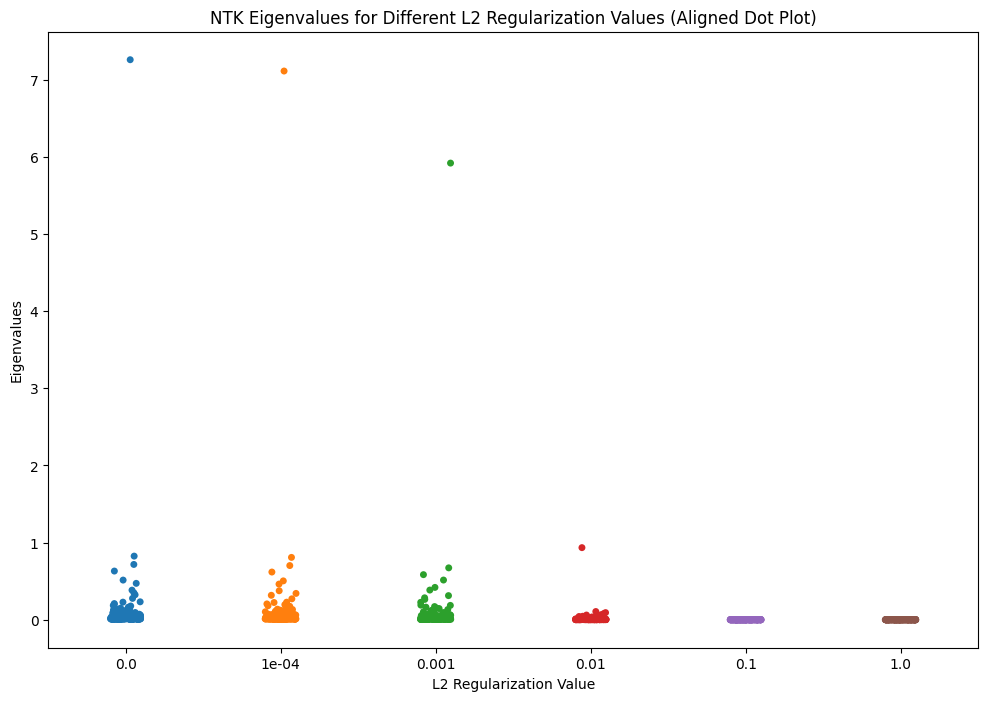

In [3]:
plt.figure(figsize=(12, 8))

sns.stripplot(data=[final_eigenvalues[float(l)] for l in l2_values], jitter=True, size=5)

plt.xticks(range(len(l2_values)), l2_values)  # Set x-axis labels
plt.xlabel("L2 Regularization Value")
plt.ylabel("Eigenvalues")
plt.title("NTK Eigenvalues for Different L2 Regularization Values (Aligned Dot Plot)")
plt.show()


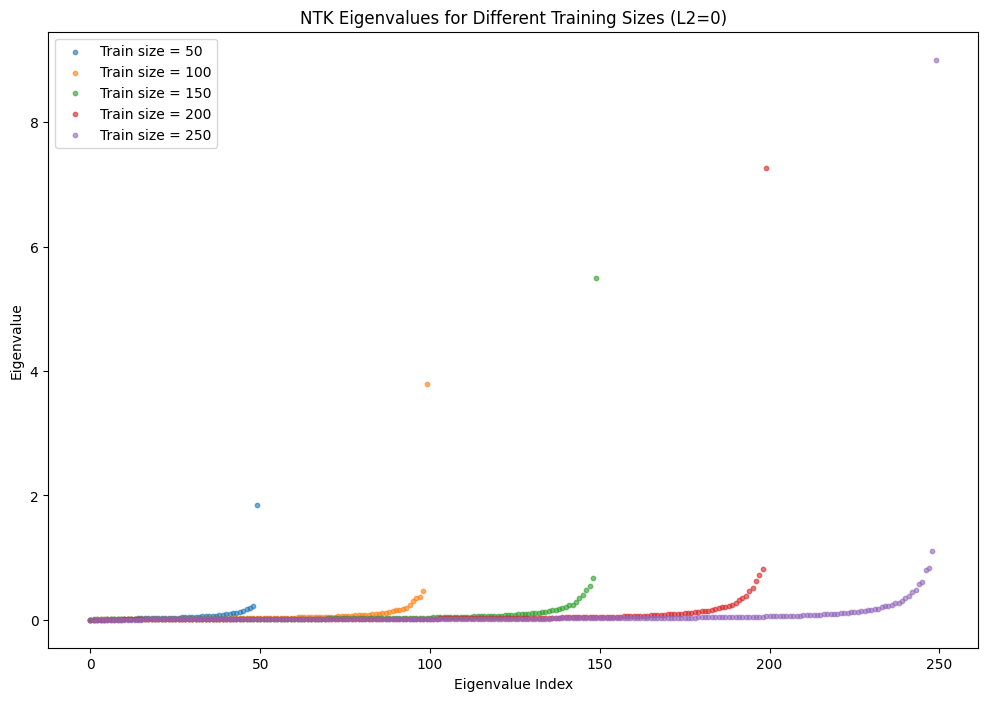

In [4]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a small MLP model
def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with fixed L2=0
def train_mlp_with_fixed_l2(x_train, y_train, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (no L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different training sizes while keeping L2=0
def track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes, epochs=100):
    final_eigenvalues = {}
    for train_size in train_sizes:
        params, apply_fn = train_mlp_with_fixed_l2(x_train, y_train, train_size, epochs)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK after training
        final_eigenvalues[train_size] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different dataset sizes
final_eigenvalues = track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes)

# Plot eigenvalues for different training sizes
plt.figure(figsize=(12, 8))
for train_size in train_sizes:
    eigvals = final_eigenvalues[train_size]
    plt.scatter(range(len(eigvals)), eigvals, label=f'Train size = {train_size}', alpha=0.6, s=10)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Training Sizes (L2=0)")
plt.show()


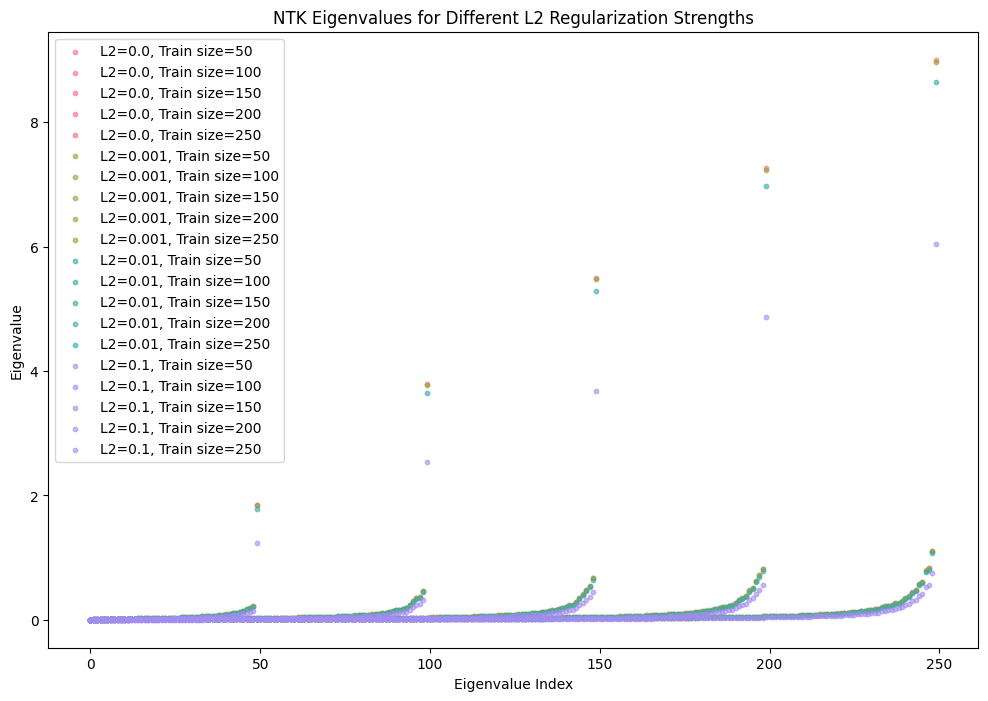

In [5]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a small MLP model
def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2 regularization
def train_mlp_with_l2(x_train, y_train, train_size, l2_strength=0.0, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        ce_loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))  # Cross-entropy loss
        l2_loss = sum(jnp.sum(p**2) for p in jax.tree_util.tree_leaves(params))  # L2 penalty
        return ce_loss + l2_strength * l2_loss  # Total loss

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different L2 values and track eigenvalues
def track_eigenvalues_with_l2(x_train, y_train, train_sizes, l2_values, epochs=100):
    final_eigenvalues = {}

    for l2 in l2_values:
        final_eigenvalues[l2] = {}

        for train_size in train_sizes:
            params, apply_fn = train_mlp_with_l2(x_train, y_train, train_size, l2_strength=l2, epochs=epochs)
            eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK
            final_eigenvalues[l2][train_size] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different dataset sizes
l2_values = [0.0, 0.001, 0.01, 0.1]  # Different L2 regularization strengths

# Track NTK eigenvalues for different L2 values
final_eigenvalues = track_eigenvalues_with_l2(x_train, y_train, train_sizes, l2_values)

# Plot eigenvalues for different L2 regularization strengths
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(l2_values))

for i, l2 in enumerate(l2_values):
    for train_size in train_sizes:
        eigvals = final_eigenvalues[l2][train_size]
        plt.scatter(range(len(eigvals)), eigvals, label=f'L2={l2}, Train size={train_size}', alpha=0.6, s=10, color=colors[i])

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different L2 Regularization Strengths")
plt.show()

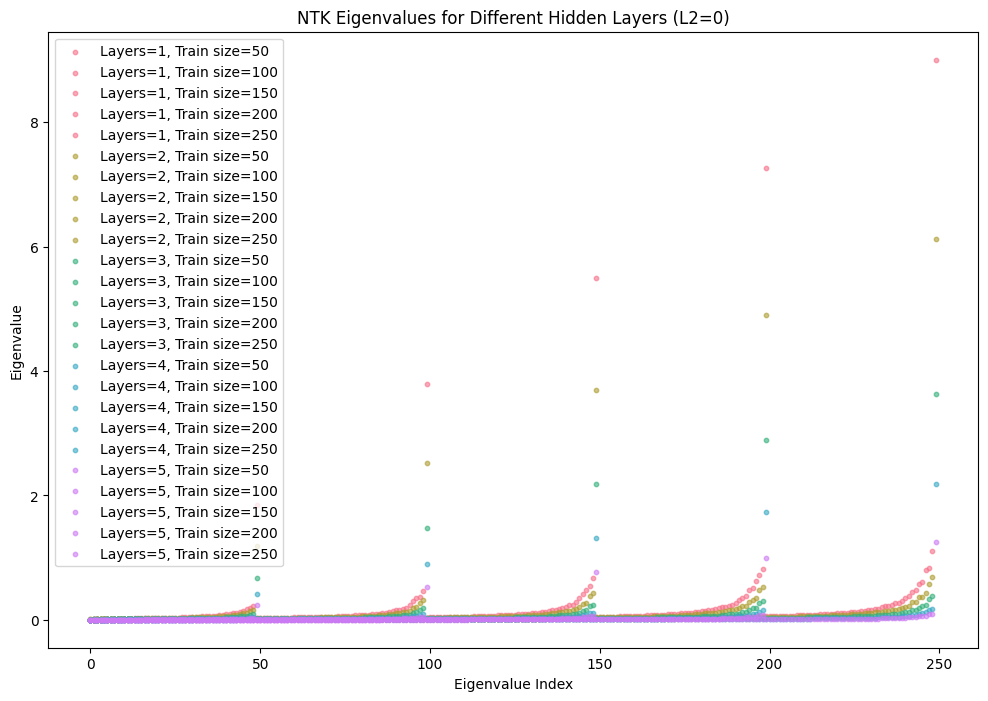

In [6]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with variable number of layers
def create_mlp(num_layers):
    layers = []
    for _ in range(num_layers):
        layers.append(stax.Dense(128))
        layers.append(stax.Relu())
    layers.append(stax.Dense(10))  # Output layer

    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with variable layers (L2 fixed at 0)
def train_mlp_with_layers(x_train, y_train, train_size, num_layers, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(num_layers)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (no L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different hidden layers and track eigenvalues
def track_eigenvalues_with_layers(x_train, y_train, train_sizes, num_layers_list, epochs=100):
    final_eigenvalues = {}

    for num_layers in num_layers_list:
        final_eigenvalues[num_layers] = {}

        for train_size in train_sizes:
            params, apply_fn = train_mlp_with_layers(x_train, y_train, train_size, num_layers, epochs)
            eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK
            final_eigenvalues[num_layers][train_size] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different dataset sizes
num_layers_list = [1, 2, 3, 4, 5]  # Vary number of hidden layers

# Track NTK eigenvalues for different numbers of layers
final_eigenvalues = track_eigenvalues_with_layers(x_train, y_train, train_sizes, num_layers_list)

# Plot eigenvalues for different numbers of hidden layers
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(num_layers_list))

for i, num_layers in enumerate(num_layers_list):
    for train_size in train_sizes:
        eigvals = final_eigenvalues[num_layers][train_size]
        plt.scatter(range(len(eigvals)), eigvals, label=f'Layers={num_layers}, Train size={train_size}', alpha=0.6, s=10, color=colors[i])

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Hidden Layers (L2=0)")
plt.show()


In [17]:
from jax.scipy.linalg import eigh


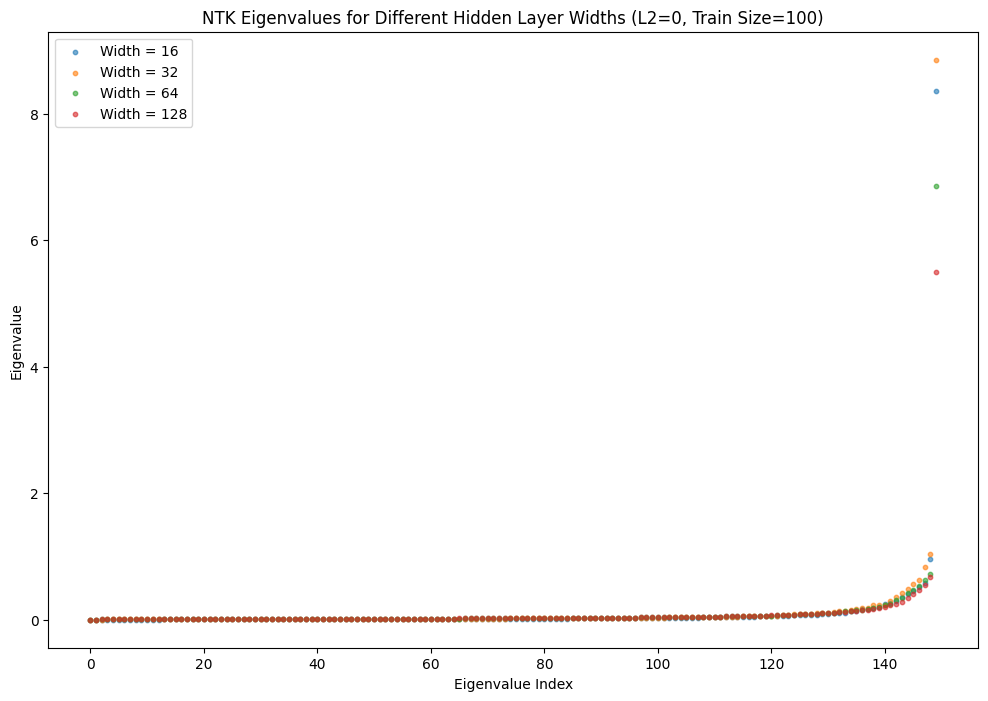

In [25]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with variable width
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with fixed L2=0
def train_mlp_with_fixed_l2(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (no L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different hidden layer widths while keeping L2=0 and training size constant
def track_eigenvalues_with_widths(x_train, y_train, widths, train_size, epochs=100):
    final_eigenvalues = {}
    for width in widths:
        params, apply_fn = train_mlp_with_fixed_l2(x_train, y_train, width, train_size, epochs)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK after training
        final_eigenvalues[width] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [16,32, 64, 128]   # Different hidden layer widths
train_size = 150  # Keeping training size constant
final_eigenvalues = track_eigenvalues_with_widths(x_train, y_train, widths, train_size)

# Plot eigenvalues for different hidden layer widths
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = final_eigenvalues[width]
    plt.scatter(range(len(eigvals)), eigvals, label=f'Width = {width}', alpha=0.6, s=10)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Hidden Layer Widths (L2=0, Train Size=100)")
plt.show()


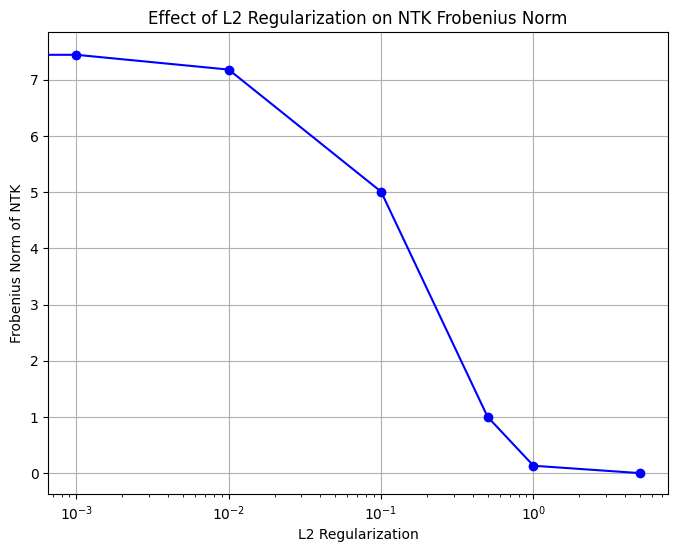

In [14]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, random
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with variable number of layers
def create_mlp(num_layers):
    layers = []
    for _ in range(num_layers):
        layers.append(stax.Dense(128))
        layers.append(stax.Relu())
    layers.append(stax.Dense(10))  # Output layer

    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    return init_fn, apply_fn, kernel_fn

# Compute Frobenius norm of the NTK matrix
def compute_frobenius_norm(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    frobenius_norm = jnp.linalg.norm(ntk_matrix, 'fro')  # Compute Frobenius norm
    return frobenius_norm

# Training function with L2 regularization
def train_mlp_with_l2(x_train, y_train, train_size, num_layers, l2_reg, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(num_layers)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        cross_entropy_loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return cross_entropy_loss + l2_reg * l2_loss  # Combine loss terms

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Track Frobenius norm for different L2 values
def track_frobenius_norm(x_train, y_train, train_size, num_layers, l2_values, epochs=100):
    frobenius_norms = {}

    for l2_reg in l2_values:
        params, apply_fn = train_mlp_with_l2(x_train, y_train, train_size, num_layers, l2_reg, epochs)
        frob_norm = compute_frobenius_norm(apply_fn, params, x_train[:train_size])
        frobenius_norms[l2_reg] = frob_norm

    return frobenius_norms

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 200  # Fixed training set size
num_layers = 1  # Fixed number of hidden layers
l2_values = [0.0,0.001, 0.01, 0.1, 0.5, 1.0, 5.0]  # Different L2 regularization values

# Track Frobenius norms
frobenius_norms = track_frobenius_norm(x_train, y_train, train_size, num_layers, l2_values)

# Plot Frobenius norm vs. L2 regularization
plt.figure(figsize=(8, 6))
plt.plot(l2_values, list(frobenius_norms.values()), marker='o', linestyle='-', color='b')
plt.xlabel("L2 Regularization")
plt.ylabel("Frobenius Norm of NTK")
plt.title("Effect of L2 Regularization on NTK Frobenius Norm")
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.show()


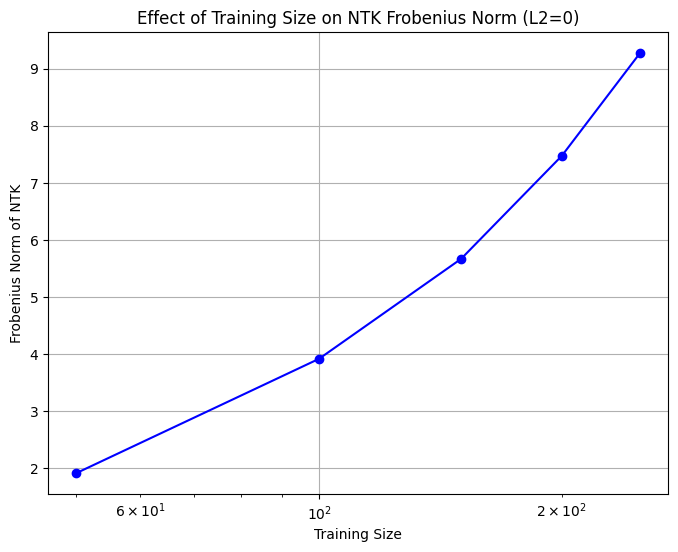

In [9]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, random
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with fixed layers
def create_mlp(num_layers=1):
    layers = []
    for _ in range(num_layers):
        layers.append(stax.Dense(128))
        layers.append(stax.Relu())
    layers.append(stax.Dense(10))  # Output layer

    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    return init_fn, apply_fn, kernel_fn

# Compute Frobenius norm of NTK
def compute_frobenius_norm(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    frobenius_norm = jnp.linalg.norm(ntk_matrix, 'fro')  # Compute Frobenius norm
    return frobenius_norm

# Training function (L2 fixed at 0)
def train_mlp(x_train, y_train, train_size, num_layers=3, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(num_layers)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (NO L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Track Frobenius norm for different training sizes
def track_frobenius_norm_by_size(x_train, y_train, train_sizes, num_layers=3, epochs=100):
    frobenius_norms = {}

    for train_size in train_sizes:
        params, apply_fn = train_mlp(x_train, y_train, train_size, num_layers, epochs)
        frob_norm = compute_frobenius_norm(apply_fn, params, x_train[:train_size])
        frobenius_norms[train_size] = frob_norm

    return frobenius_norms

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50,100,150,200,250]  # Varying dataset sizes
num_layers = 1  # Fixed number of layers

# Compute Frobenius norm for different training sizes
frobenius_norms = track_frobenius_norm_by_size(x_train, y_train, train_sizes, num_layers)

# Plot Frobenius norm vs. training size
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, list(frobenius_norms.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Training Size")
plt.ylabel("Frobenius Norm of NTK")
plt.title("Effect of Training Size on NTK Frobenius Norm (L2=0)")
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.show()


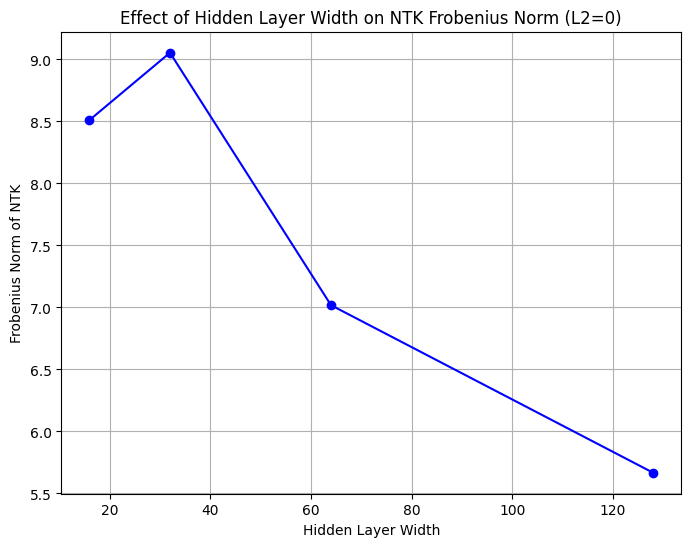

In [13]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, random
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a single-layer MLP with variable width
def create_mlp(hidden_width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(hidden_width),
        stax.Relu(),
        stax.Dense(10)  # Output layer
    )
    return init_fn, apply_fn, kernel_fn

# Compute Frobenius norm of NTK
def compute_frobenius_norm(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    frobenius_norm = jnp.linalg.norm(ntk_matrix, 'fro')  # Compute Frobenius norm
    return frobenius_norm

# Training function (L2 fixed at 0)
def train_mlp(x_train, y_train, train_size, hidden_width, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(hidden_width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (NO L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Track Frobenius norm for different hidden layer widths
def track_frobenius_norm_by_width(x_train, y_train, train_size, width_list, epochs=100):
    frobenius_norms = {}

    for hidden_width in width_list:
        params, apply_fn = train_mlp(x_train, y_train, train_size, hidden_width, epochs)
        frob_norm = compute_frobenius_norm(apply_fn, params, x_train[:train_size])
        frobenius_norms[hidden_width] = frob_norm

    return frobenius_norms

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 150  # Fixed training size
width_list = [16, 32, 64, 128,]  # Vary width of the single hidden layer

# Compute Frobenius norm for different hidden layer widths
frobenius_norms = track_frobenius_norm_by_width(x_train, y_train, train_size, width_list)

# Plot Frobenius norm vs. hidden layer width
plt.figure(figsize=(8, 6))
plt.plot(width_list, list(frobenius_norms.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Hidden Layer Width")
plt.ylabel("Frobenius Norm of NTK")
plt.title("Effect of Hidden Layer Width on NTK Frobenius Norm (L2=0)")
plt.grid(True)
plt.show()

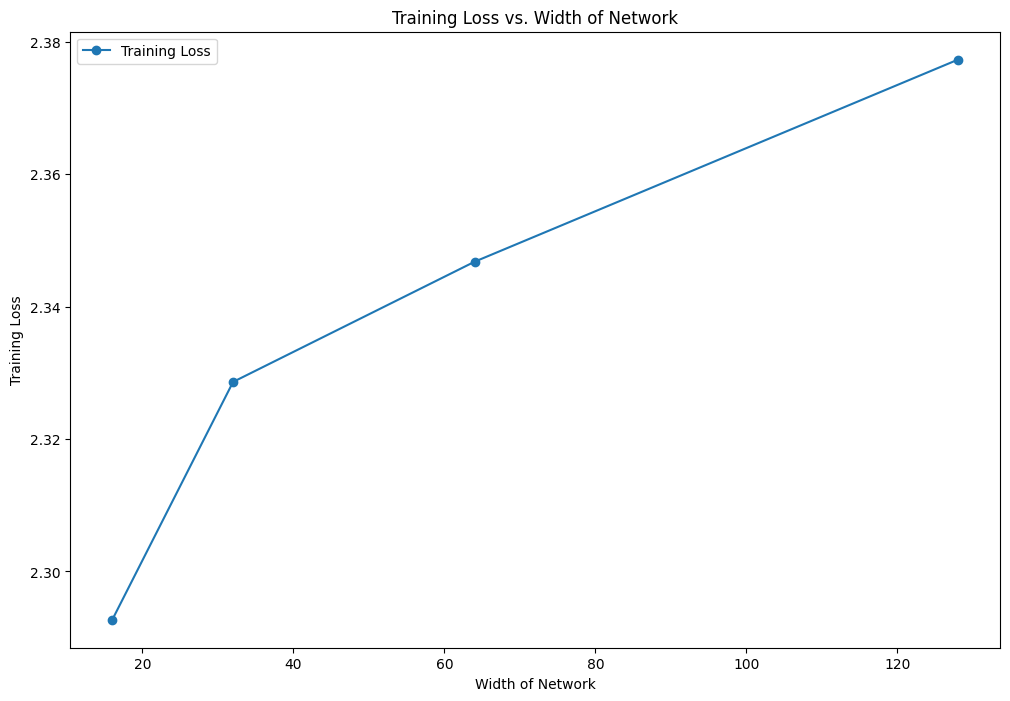

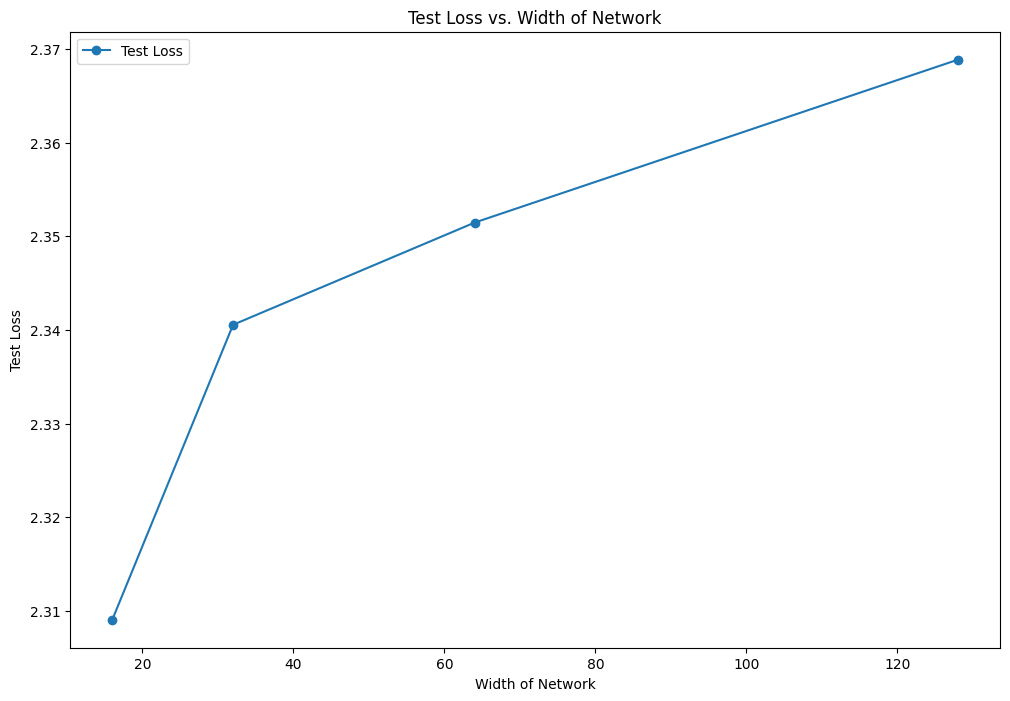

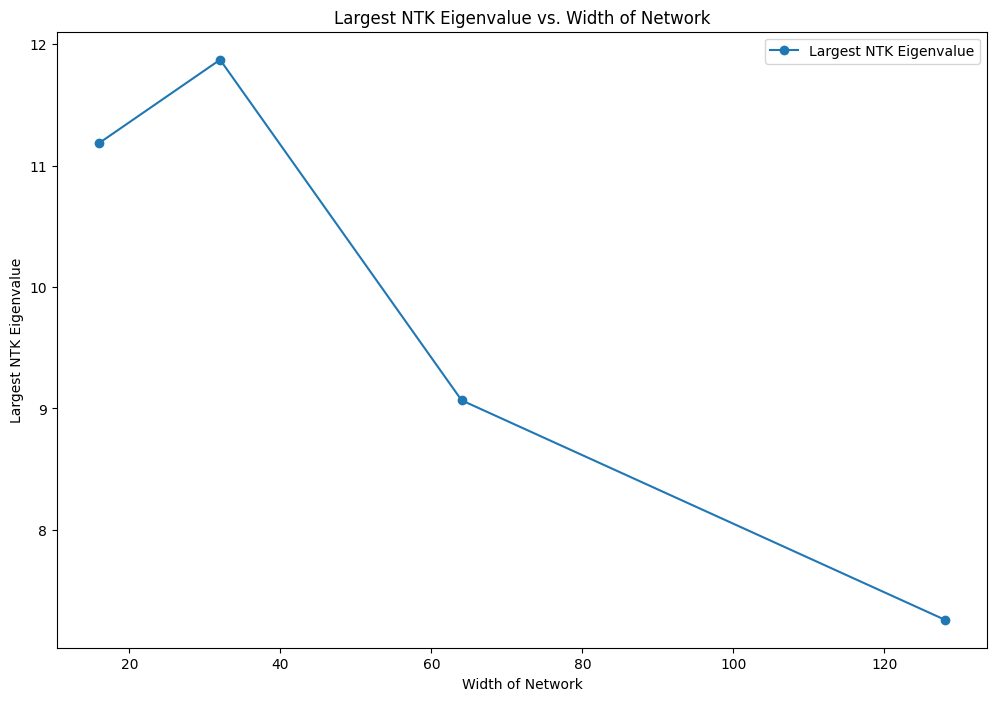

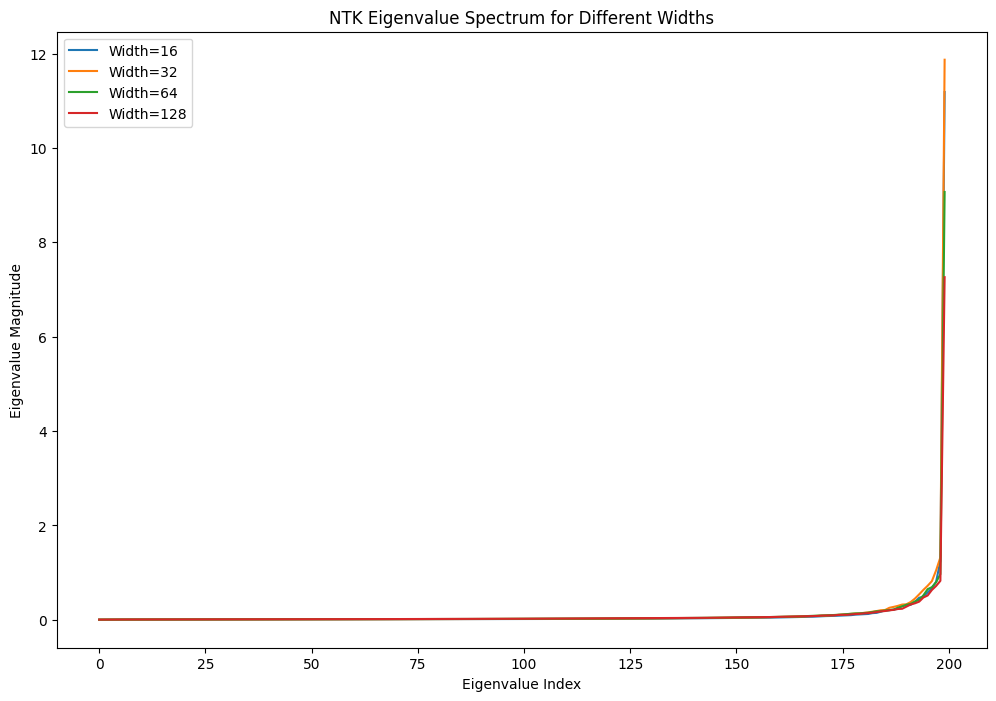

In [10]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    eigenvalue_spectra = []
    training_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute NTK eigenvalues
        eigenvalues = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
        eigenvalue_spectra.append(eigenvalues)
        
        # Compute training loss
        train_loss = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(train_loss)
        
        # Compute test loss
        test_loss = loss_fn(params, x_test, y_test)
        test_losses.append(test_loss)
    
    return eigenvalue_spectra, training_losses, test_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [16, 32, 64, 128]  # Different network widths
train_size = 200  # Keeping training size constant
results = {}

for width in widths:
    eigenvalue_spectra, training_losses, test_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (eigenvalue_spectra, training_losses, test_losses)

# Plot training loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][1][-1] for w in widths], marker='o', label='Training Loss')
plt.xlabel("Width of Network")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss vs. Width of Network")
plt.show()

# Plot test loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][2][-1] for w in widths], marker='o', label='Test Loss')
plt.xlabel("Width of Network")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss vs. Width of Network")
plt.show()

# Plot largest eigenvalue vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][0][-1][-1] for w in widths], marker='o', label='Largest NTK Eigenvalue')
plt.xlabel("Width of Network")
plt.ylabel("Largest NTK Eigenvalue")
plt.legend()
plt.title("Largest NTK Eigenvalue vs. Width of Network")
plt.show()

# Plot eigenvalue spectra for different widths
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]  # Take final epoch eigenvalues
    plt.plot(range(len(eigvals)), eigvals, label=f'Width={width}')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")
plt.legend()
plt.title("NTK Eigenvalue Spectrum for Different Widths")
plt.show()

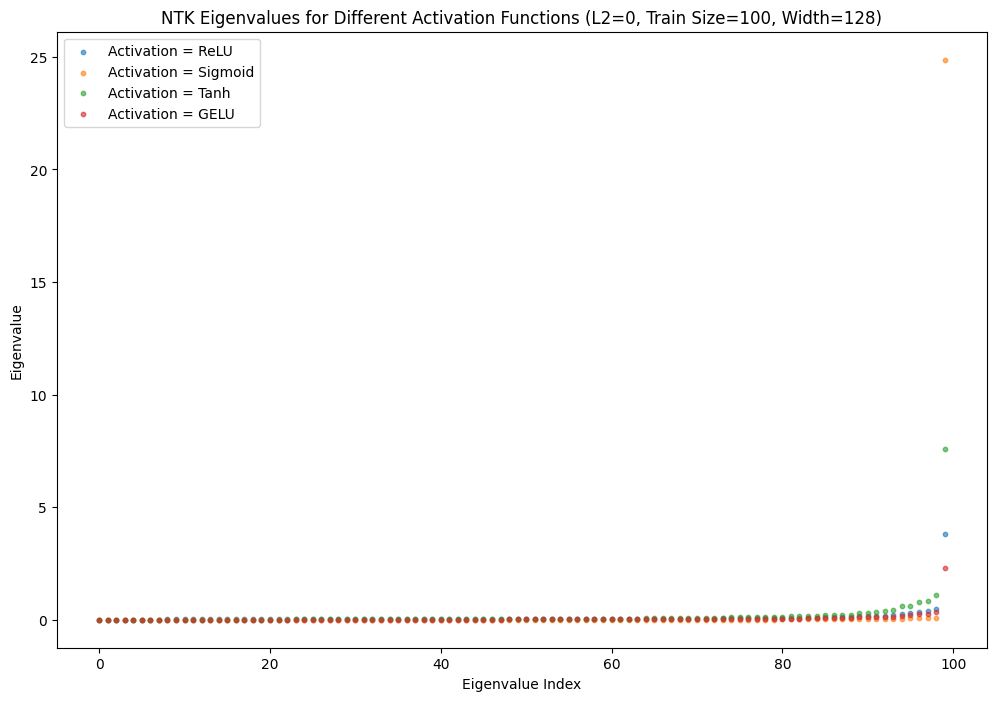

In [27]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with variable activation function
def create_mlp(width, activation):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), activation,
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with fixed L2=0
def train_mlp_with_fixed_l2(x_train, y_train, width, activation, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width, activation)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (no L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different activation functions while keeping L2=0 and training size constant
def track_eigenvalues_with_activations(x_train, y_train, activations, train_size, width, epochs=100):
    final_eigenvalues = {}
    for name, activation in activations.items():
        params, apply_fn = train_mlp_with_fixed_l2(x_train, y_train, width, activation, train_size, epochs)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK after training
        final_eigenvalues[name] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
activations = {"ReLU": stax.Relu(), "Sigmoid": stax.Elementwise(jax.nn.sigmoid), "Tanh": stax.Elementwise(jax.nn.tanh), "GELU": stax.Elementwise(jax.nn.gelu)}
train_size = 100  # Keeping training size constant
width = 128  # Keeping width constant
final_eigenvalues = track_eigenvalues_with_activations(x_train, y_train, activations, train_size, width)

# Plot eigenvalues for different activation functions
plt.figure(figsize=(12, 8))
for name in activations.keys():
    eigvals = final_eigenvalues[name]
    plt.scatter(range(len(eigvals)), eigvals, label=f'Activation = {name}', alpha=0.6, s=10)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Activation Functions (L2=0, Train Size=100, Width=128)")
plt.show()

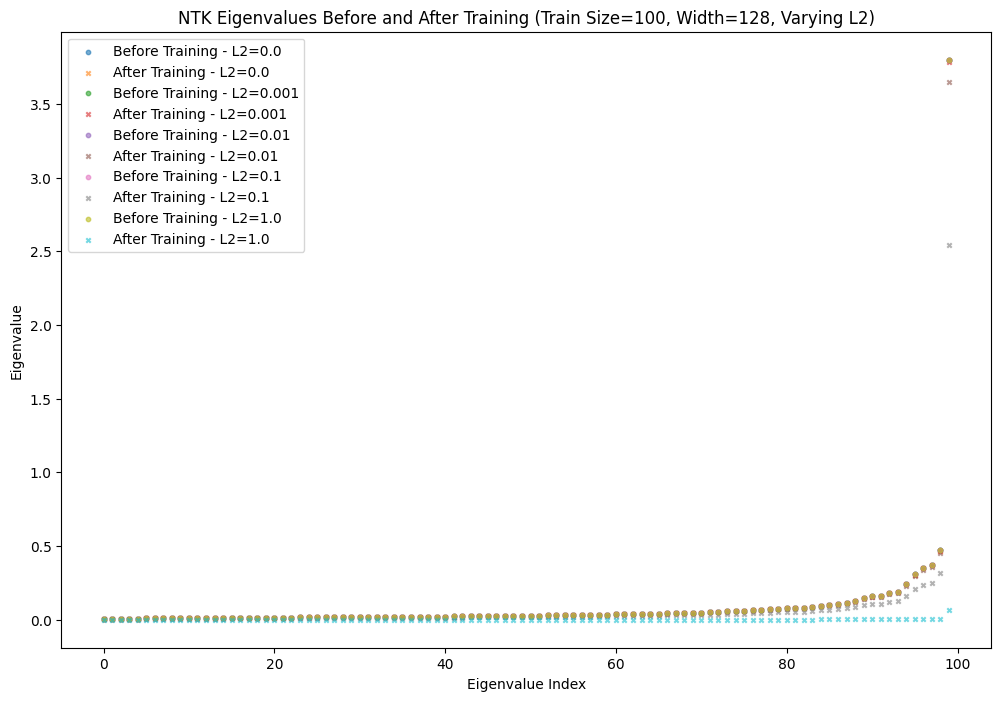

In [29]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model with L2 regularization
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with variable L2 regularization
def train_mlp_with_l2(x_train, y_train, width, l2_reg, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Compute NTK before training
    ntk_before = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
        l2_loss = sum(jnp.sum(p**2) for p in jax.tree_util.tree_leaves(params))
        return loss + l2_reg * l2_loss

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    # Compute NTK after training
    ntk_after = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])

    return params, apply_fn, ntk_before, ntk_after  # Return trained parameters and function

# Train model with different L2 regularizations while keeping other parameters constant
def track_eigenvalues_with_l2(x_train, y_train, l2_values, train_size, width, epochs=100):
    eigenvalues_before_after = {}
    for l2_reg in l2_values:
        params, apply_fn, ntk_before, ntk_after = train_mlp_with_l2(x_train, y_train, width, l2_reg, train_size, epochs)
        eigenvalues_before_after[l2_reg] = (ntk_before, ntk_after)

    return eigenvalues_before_after

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
l2_values = [0.0, 0.001, 0.01, 0.1, 1.0]  # Different L2 regularization values
train_size = 100  # Keeping training size constant
width = 128  # Keeping width constant
eigenvalues_before_after = track_eigenvalues_with_l2(x_train, y_train, l2_values, train_size, width)

# Plot eigenvalues before and after training for different L2 regularizations
plt.figure(figsize=(12, 8))
for l2_reg in l2_values:
    ntk_before, ntk_after = eigenvalues_before_after[l2_reg]
    plt.scatter(range(len(ntk_before)), ntk_before, label=f'Before Training - L2={l2_reg}', alpha=0.6, s=10)
    plt.scatter(range(len(ntk_after)), ntk_after, label=f'After Training - L2={l2_reg}', alpha=0.6, s=10, marker='x')

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues Before and After Training (Train Size=100, Width=128, Varying L2)")
plt.show()


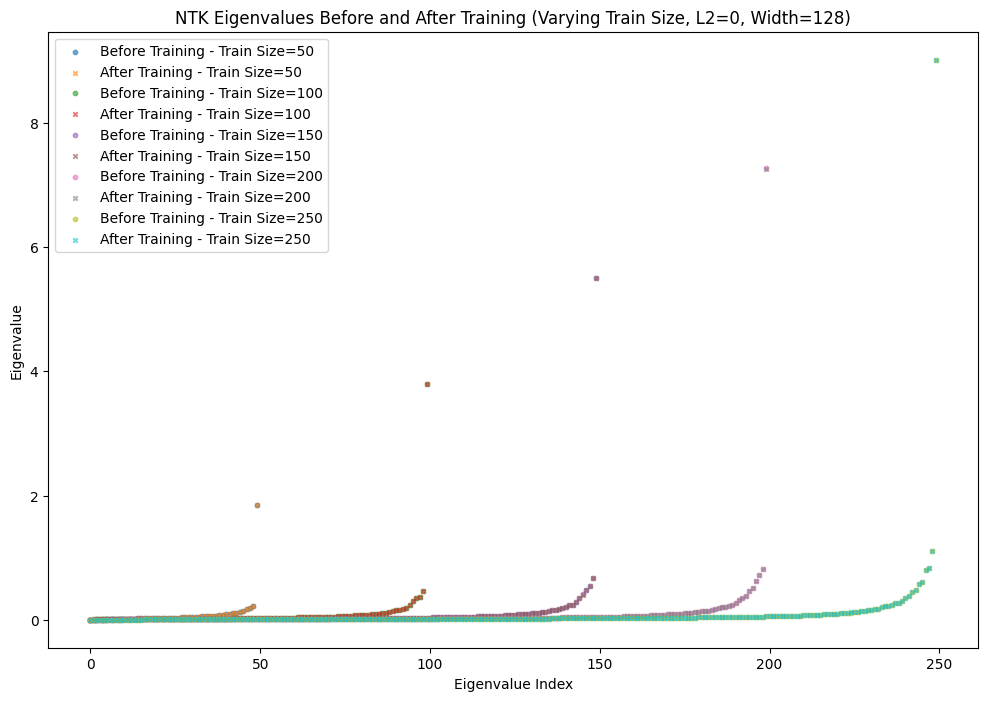

In [31]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2 regularization fixed at 0
def train_mlp_with_train_sizes(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Compute NTK before training
    ntk_before = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])

    # Define loss function (no L2 regularization)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    # Compute NTK after training
    ntk_after = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])

    return params, apply_fn, ntk_before, ntk_after  # Return trained parameters and function

# Train model with different training sizes while keeping L2 regularization at 0
def track_eigenvalues_with_train_sizes(x_train, y_train, train_sizes, width, epochs=100):
    eigenvalues_before_after = {}
    for train_size in train_sizes:
        params, apply_fn, ntk_before, ntk_after = train_mlp_with_train_sizes(x_train, y_train, width, train_size, epochs)
        eigenvalues_before_after[train_size] = (ntk_before, ntk_after)

    return eigenvalues_before_after

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
width = 128  # Keeping width constant
eigenvalues_before_after = track_eigenvalues_with_train_sizes(x_train, y_train, train_sizes, width)

# Plot eigenvalues before and after training for different training sizes
plt.figure(figsize=(12, 8))
for train_size in train_sizes:
    ntk_before, ntk_after = eigenvalues_before_after[train_size]
    plt.scatter(range(len(ntk_before)), ntk_before, label=f'Before Training - Train Size={train_size}', alpha=0.6, s=10)
    plt.scatter(range(len(ntk_after)), ntk_after, label=f'After Training - Train Size={train_size}', alpha=0.6, s=10, marker='x')

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues Before and After Training (Varying Train Size, L2=0, Width=128)")
plt.show()


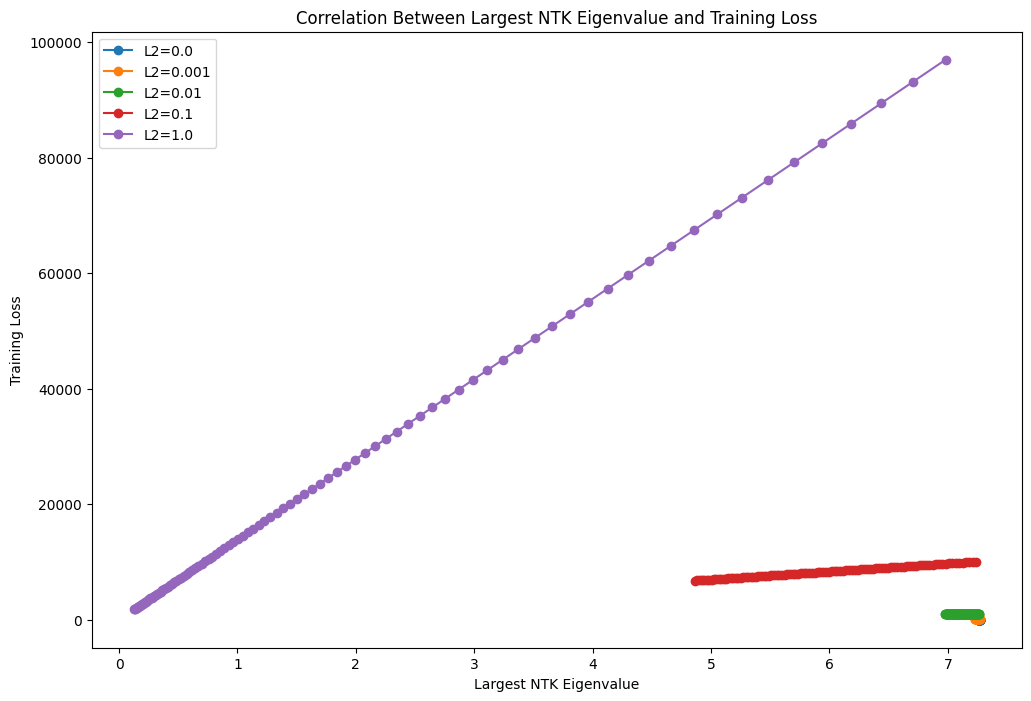

In [33]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with varying L2 regularization
def train_mlp_with_l2(x_train, y_train, width, train_size, l2, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return loss + l2 * l2_loss

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        loss_value = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(loss_value)

    return largest_eigenvalues, training_losses

# Train model with different L2 regularization values while keeping training size constant
def track_eigenvalues_vs_loss(x_train, y_train, train_size, width, l2_values, epochs=100):
    results = {}
    for l2 in l2_values:
        largest_eigenvalues, training_losses = train_mlp_with_l2(x_train, y_train, width, train_size, l2, epochs)
        results[l2] = (largest_eigenvalues, training_losses)
    return results

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 200  # Keeping training size constant
width = 128  # Keeping width constant
l2_values = [0.0, 0.001, 0.01, 0.1, 1.0]  # Different L2 regularization values
results = track_eigenvalues_vs_loss(x_train, y_train, train_size, width, l2_values)

# Plot largest eigenvalue vs. training loss
plt.figure(figsize=(12, 8))
for l2 in l2_values:
    largest_eigenvalues, training_losses = results[l2]
    plt.plot(largest_eigenvalues, training_losses, label=f'L2={l2}', marker='o')

plt.xlabel("Largest NTK Eigenvalue")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Correlation Between Largest NTK Eigenvalue and Training Loss")
plt.show()

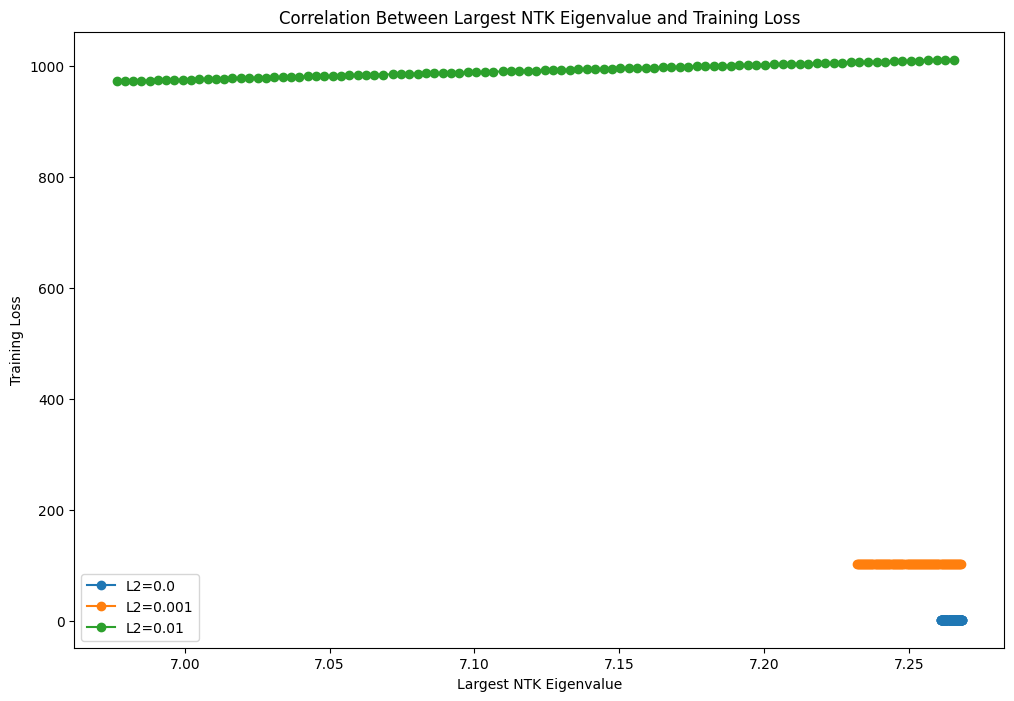

In [8]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with varying L2 regularization
def train_mlp_with_l2(x_train, y_train, width, train_size, l2, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L2 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return loss + l2 * l2_loss

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        loss_value = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(loss_value)

    return largest_eigenvalues, training_losses

# Train model with different L2 regularization values while keeping training size constant
def track_eigenvalues_vs_loss(x_train, y_train, train_size, width, l2_values, epochs=100):
    results = {}
    for l2 in l2_values:
        largest_eigenvalues, training_losses = train_mlp_with_l2(x_train, y_train, width, train_size, l2, epochs)
        results[l2] = (largest_eigenvalues, training_losses)
    return results

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 200  # Keeping training size constant
width = 128  # Keeping width constant
l2_values = [0.0, 0.001, 0.01]  # Different L2 regularization values
results = track_eigenvalues_vs_loss(x_train, y_train, train_size, width, l2_values)

# Plot largest eigenvalue vs. training loss
plt.figure(figsize=(12, 8))
for l2 in l2_values:
    largest_eigenvalues, training_losses = results[l2]
    plt.plot(largest_eigenvalues, training_losses, label=f'L2={l2}', marker='o')

plt.xlabel("Largest NTK Eigenvalue")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Correlation Between Largest NTK Eigenvalue and Training Loss")
plt.show()

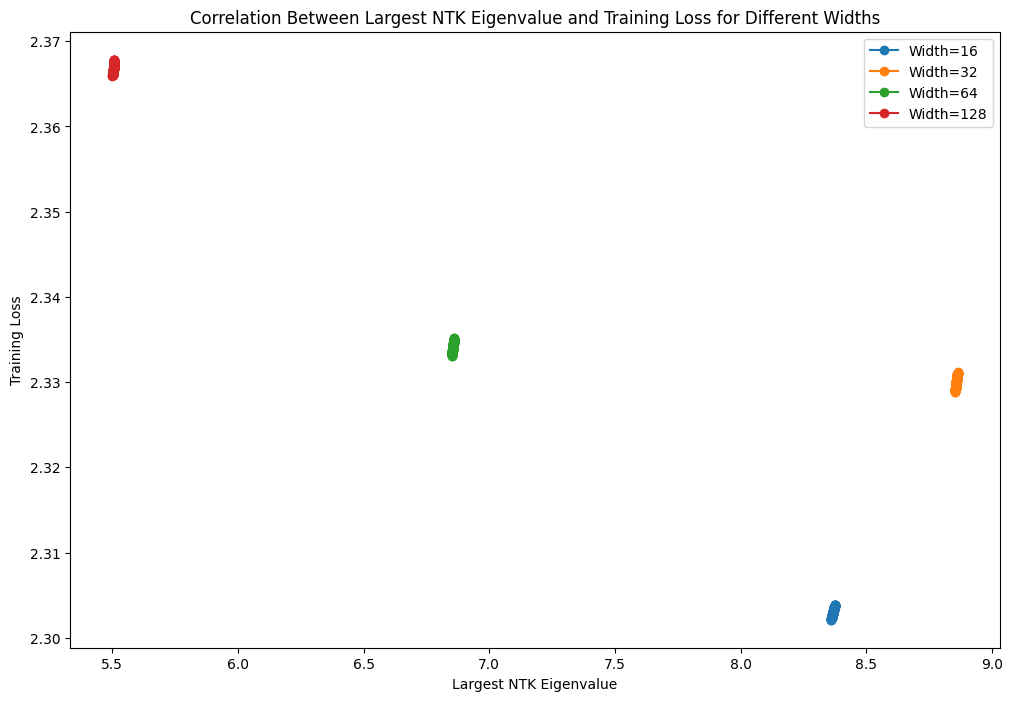

In [9]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        loss_value = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(loss_value)

    return largest_eigenvalues, training_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 150  # Keeping training size constant
width_values = [16, 32, 64, 128,]  # Different layer widths
results = {}

for width in width_values:
    largest_eigenvalues, training_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (largest_eigenvalues, training_losses)

# Plot largest eigenvalue vs. training loss
plt.figure(figsize=(12, 8))
for width in width_values:
    largest_eigenvalues, training_losses = results[width]
    plt.plot(largest_eigenvalues, training_losses, label=f'Width={width}', marker='o')

plt.xlabel("Largest NTK Eigenvalue")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Correlation Between Largest NTK Eigenvalue and Training Loss for Different Widths")
plt.show()

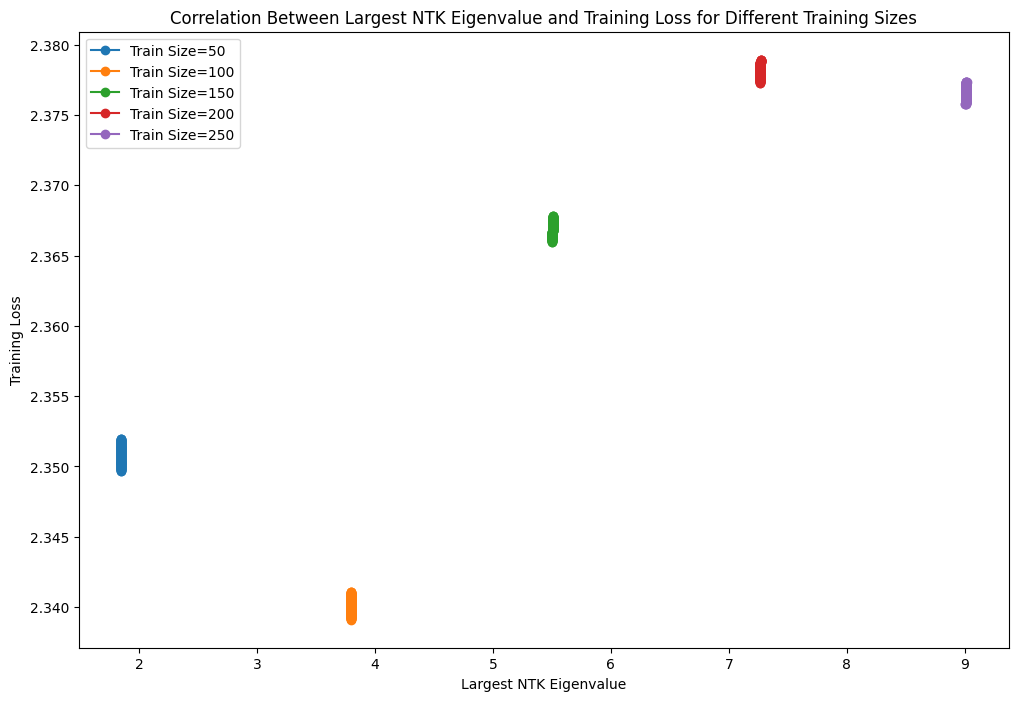

In [5]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        loss_value = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(loss_value)

    return largest_eigenvalues, training_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
width = 128  # Keeping width constant
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
results = {}

for train_size in train_sizes:
    largest_eigenvalues, training_losses = train_mlp(x_train, y_train, width, train_size)
    results[train_size] = (largest_eigenvalues, training_losses)

# Plot largest eigenvalue vs. training loss
plt.figure(figsize=(12, 8))
for train_size in train_sizes:
    largest_eigenvalues, training_losses = results[train_size]
    plt.plot(largest_eigenvalues, training_losses, label=f'Train Size={train_size}', marker='o')

plt.xlabel("Largest NTK Eigenvalue")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Correlation Between Largest NTK Eigenvalue and Training Loss for Different Training Sizes")
plt.show()

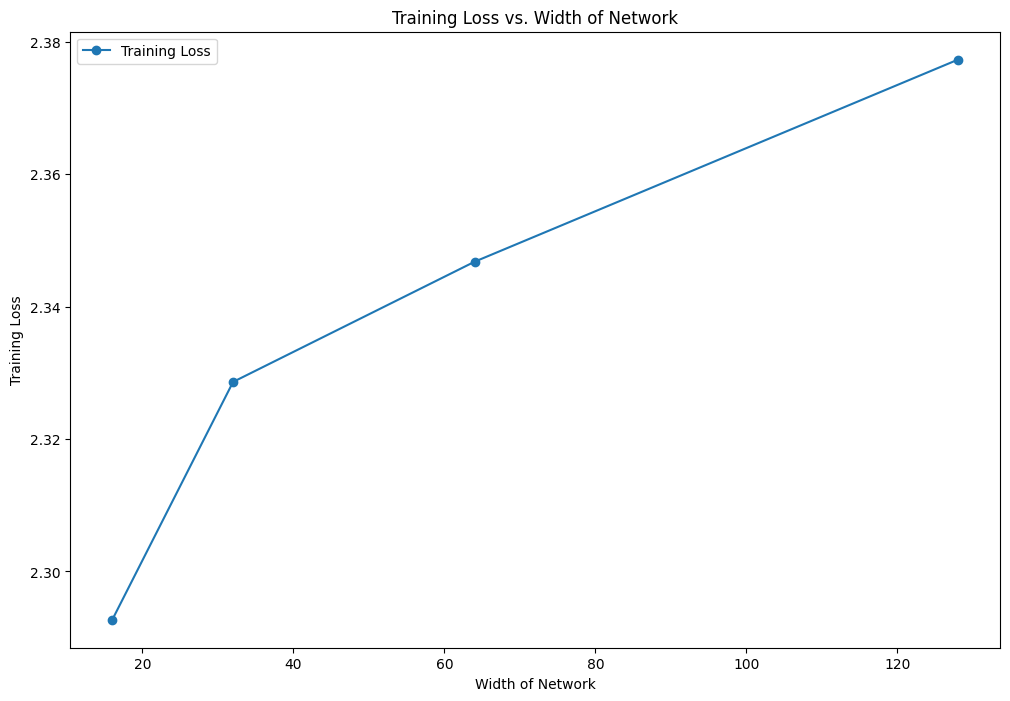

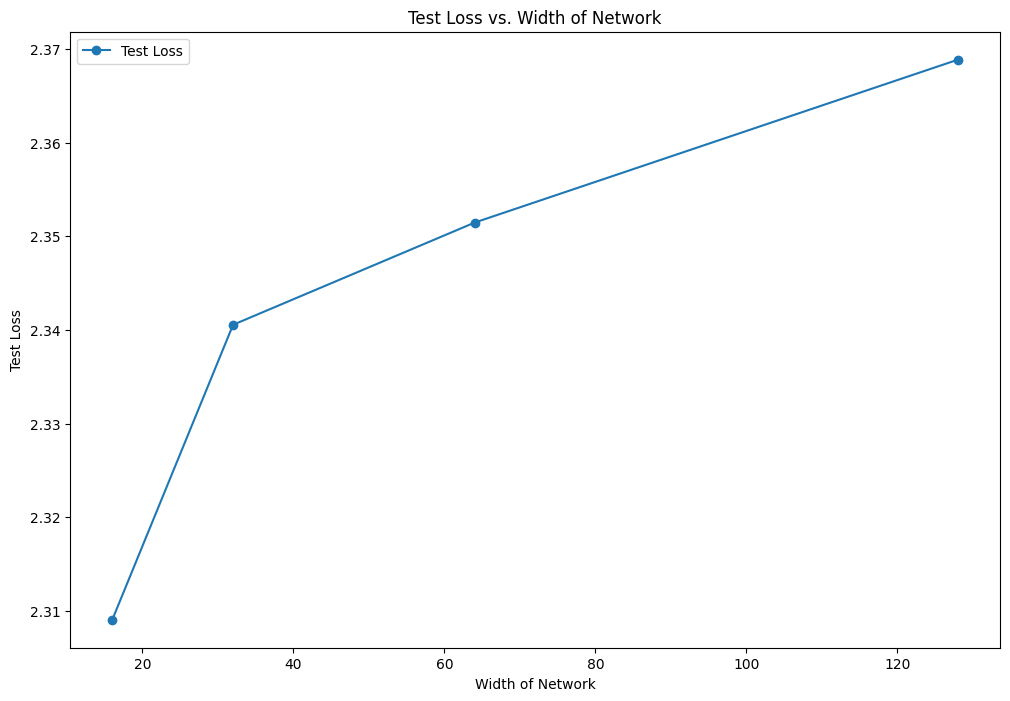

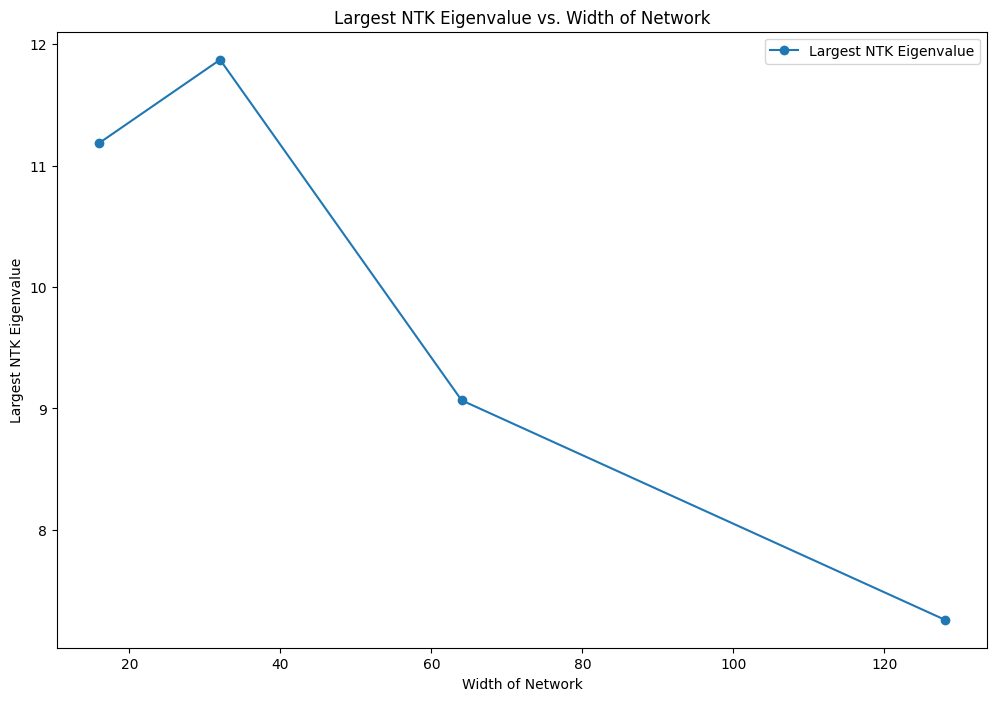

In [6]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        train_loss = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(train_loss)
        
        # Compute test loss
        test_loss = loss_fn(params, x_test, y_test)
        test_losses.append(test_loss)
    
    return largest_eigenvalues, training_losses, test_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [16, 32, 64, 128]  # Different network widths
train_size = 200  # Keeping training size constant
results = {}

for width in widths:
    largest_eigenvalues, training_losses, test_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (largest_eigenvalues, training_losses, test_losses)

# Plot training loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][1][-1] for w in widths], marker='o', label='Training Loss')
plt.xlabel("Width of Network")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss vs. Width of Network")
plt.show()

# Plot test loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][2][-1] for w in widths], marker='o', label='Test Loss')
plt.xlabel("Width of Network")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss vs. Width of Network")
plt.show()

# Plot largest eigenvalue vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][0][-1] for w in widths], marker='o', label='Largest NTK Eigenvalue')
plt.xlabel("Width of Network")
plt.ylabel("Largest NTK Eigenvalue")
plt.legend()
plt.title("Largest NTK Eigenvalue vs. Width of Network")
plt.show()


Width=16: Mean=0.1099, Variance=0.6351, Skewness=13.4445, Kurtosis=183.5995
Width=32: Mean=0.1243, Variance=0.7188, Skewness=13.3233, Kurtosis=181.2677
Width=64: Mean=0.1055, Variance=0.4197, Skewness=13.2617, Kurtosis=180.1354
Width=128: Mean=0.0929, Variance=0.2706, Skewness=13.1154, Kurtosis=177.3165


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

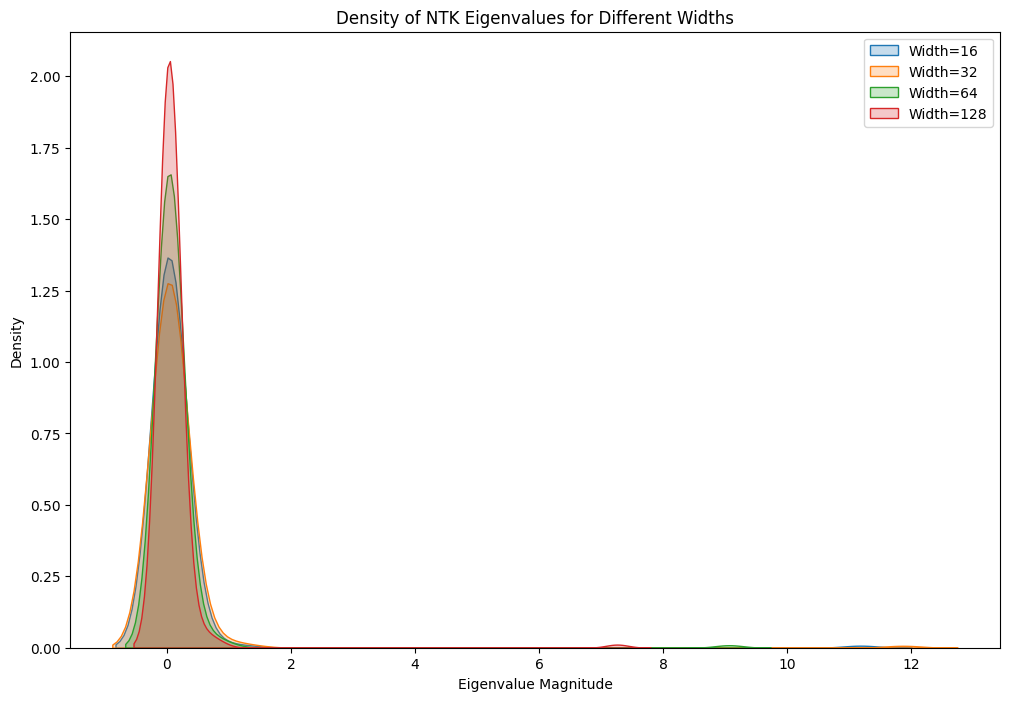

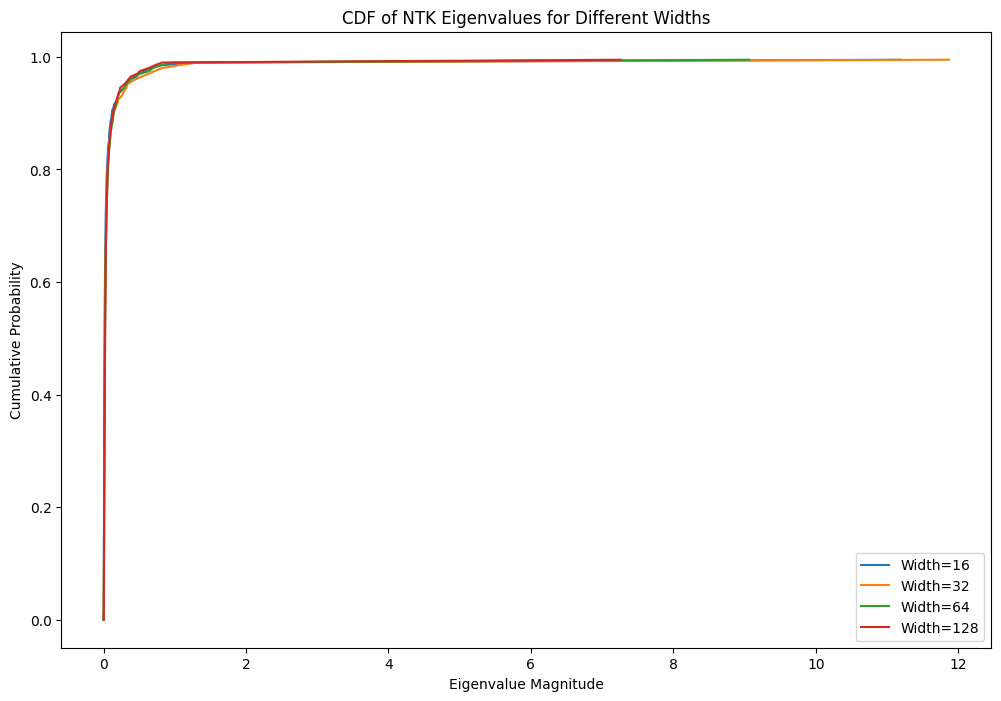

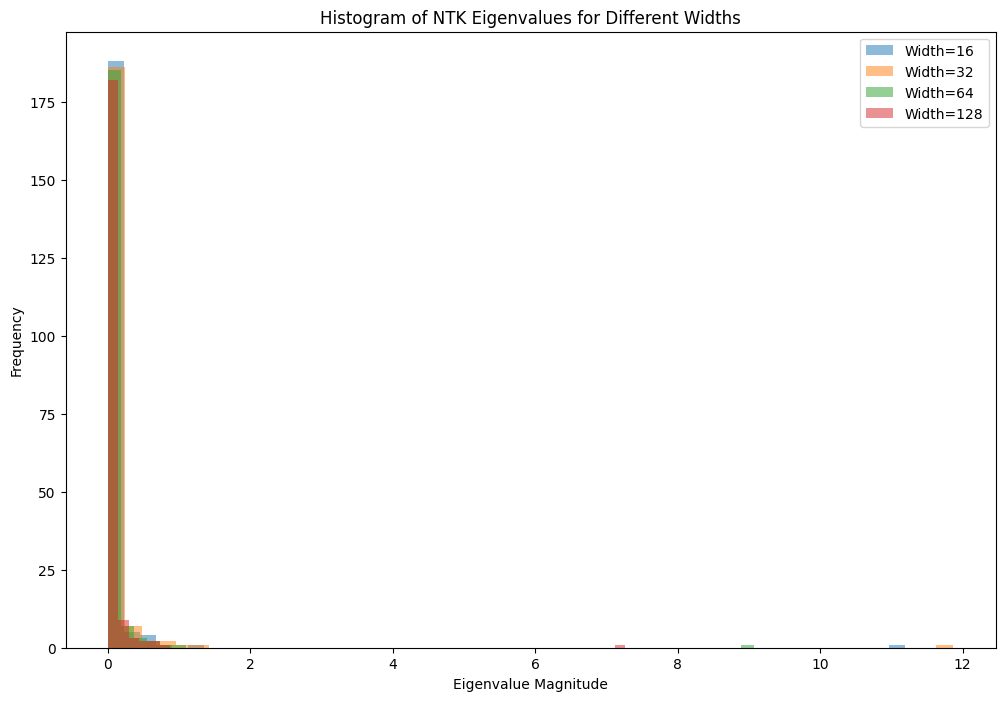

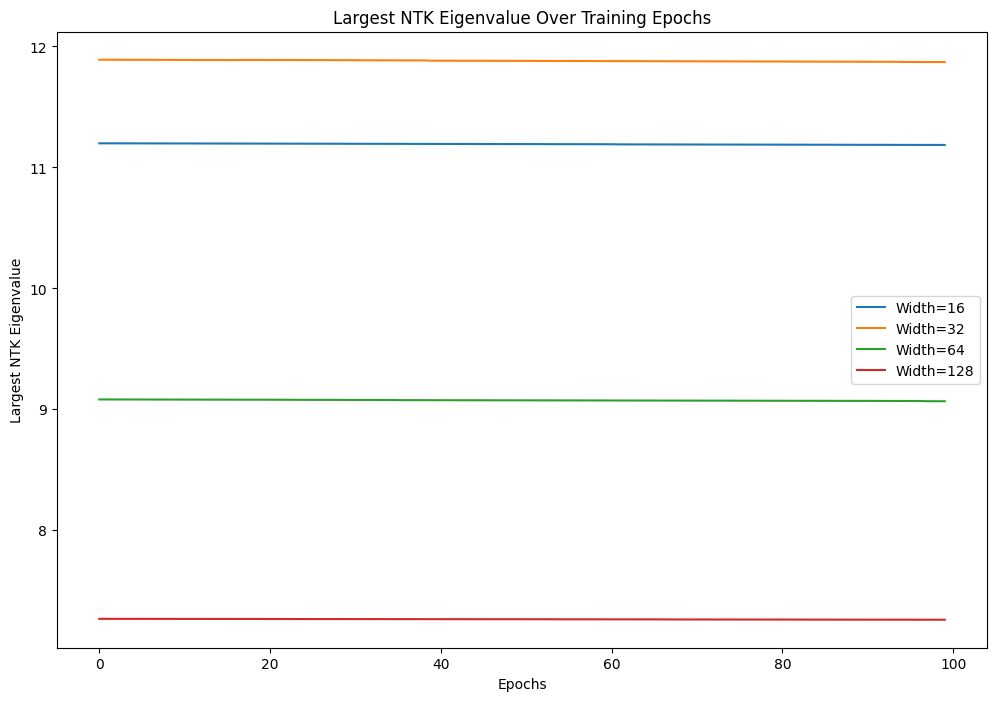

In [11]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    eigenvalue_spectra = []
    training_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute NTK eigenvalues
        eigenvalues = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
        eigenvalue_spectra.append(eigenvalues)
        
        # Compute training loss
        train_loss = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(train_loss)
        
        # Compute test loss
        test_loss = loss_fn(params, x_test, y_test)
        test_losses.append(test_loss)
    
    return eigenvalue_spectra, training_losses, test_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [16, 32, 64, 128]  # Different network widths
train_size = 200  # Keeping training size constant
results = {}

for width in widths:
    eigenvalue_spectra, training_losses, test_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (eigenvalue_spectra, training_losses, test_losses)

# Statistical analysis of NTK eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]  # Final epoch eigenvalues
    mean_val = jnp.mean(eigvals)
    var_val = jnp.var(eigvals)
    skew_val = stats.skew(eigvals)
    kurtosis_val = stats.kurtosis(eigvals)
    print(f"Width={width}: Mean={mean_val:.4f}, Variance={var_val:.4f}, Skewness={skew_val:.4f}, Kurtosis={kurtosis_val:.4f}")
    
    sns.kdeplot(eigvals, label=f'Width={width}', fill=True)

plt.xlabel("Eigenvalue Magnitude")
plt.ylabel("Density")
plt.legend()
plt.title("Density of NTK Eigenvalues for Different Widths")
plt.show()

# Cumulative Distribution Function (CDF) of Eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]
    sorted_eigvals = jnp.sort(eigvals)
    cdf = jnp.arange(len(sorted_eigvals)) / len(sorted_eigvals)
    plt.plot(sorted_eigvals, cdf, label=f'Width={width}')

plt.xlabel("Eigenvalue Magnitude")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.title("CDF of NTK Eigenvalues for Different Widths")
plt.show()

# Histogram of Eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]
    plt.hist(eigvals, bins=50, alpha=0.5, label=f'Width={width}')

plt.xlabel("Eigenvalue Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of NTK Eigenvalues for Different Widths")
plt.show()

# Track the largest eigenvalue over epochs
plt.figure(figsize=(12, 8))
for width in widths:
    largest_eigenvalues = [epoch_eigvals[-1] for epoch_eigvals in results[width][0]]
    plt.plot(range(len(largest_eigenvalues)), largest_eigenvalues, label=f'Width={width}')

plt.xlabel("Epochs")
plt.ylabel("Largest NTK Eigenvalue")
plt.legend()
plt.title("Largest NTK Eigenvalue Over Training Epochs")
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


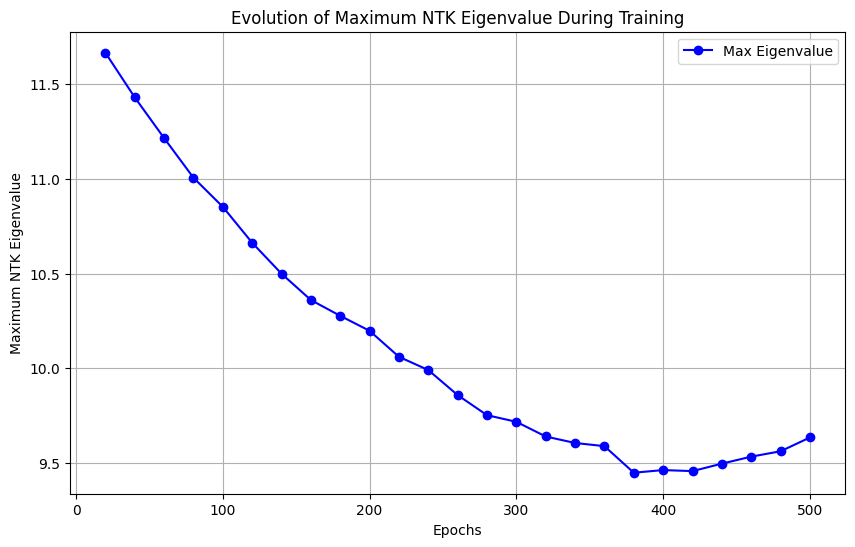

In [2]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a small MLP model
def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)  # Ensure batch processing
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)  # Compute NTK

    if ntk_matrix.ndim == 3:  
        ntk_matrix = ntk_matrix.mean(axis=-1)  # Convert (N, N, C) → (N, N)

    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Train model while tracking NTK evolution
def train_and_track_ntk(x_train, y_train, train_size, epochs=500, learning_rate=0.1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    grad_fn = grad(loss_fn)  # Compute gradients
    max_eigenvalues = {}  # Store max eigenvalue at each tracked epoch

    # Training loop
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

        if epoch % 20 == 0:  # Track NTK at multiples of 20
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)  # Store only the maximum eigenvalue

    return params, apply_fn, max_eigenvalues  # Return trained parameters and max eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_size = 200  # Fix dataset size
epochs = 500  # Total training epochs

params, apply_fn, max_eigenvalues = train_and_track_ntk(x_train, y_train, train_size, epochs)

# Plot maximum NTK eigenvalue vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', color='b', label="Max Eigenvalue")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue During Training")
plt.legend()
plt.grid(True)
plt.show()


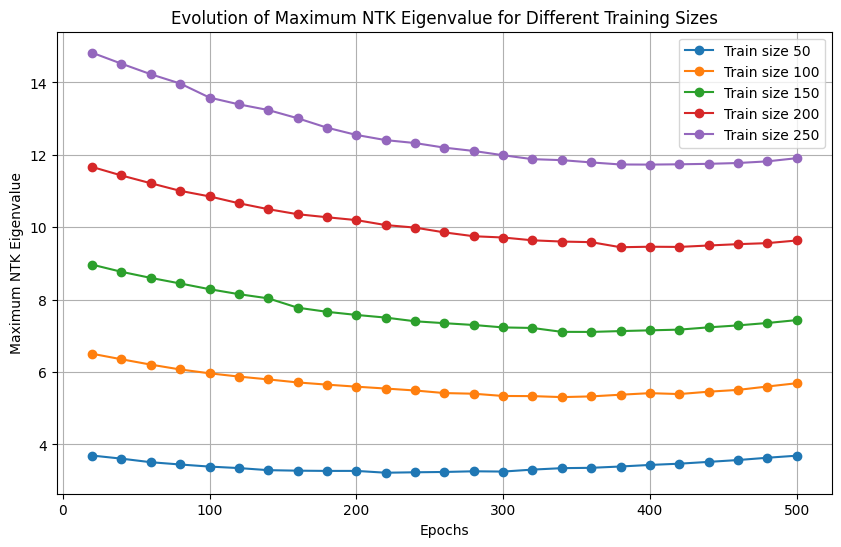

In [3]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=500, learning_rate=0.1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))a
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250] # Different training sizes
epochs = 500

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()

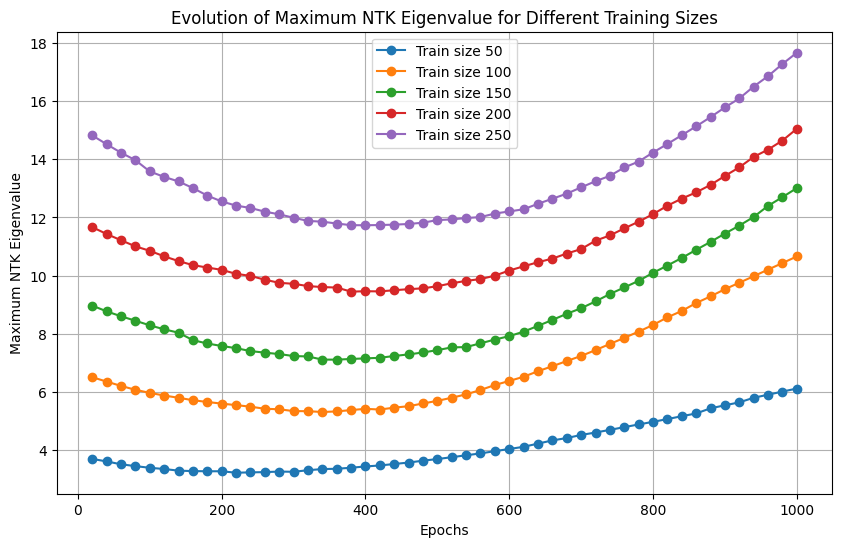

In [16]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250] # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()

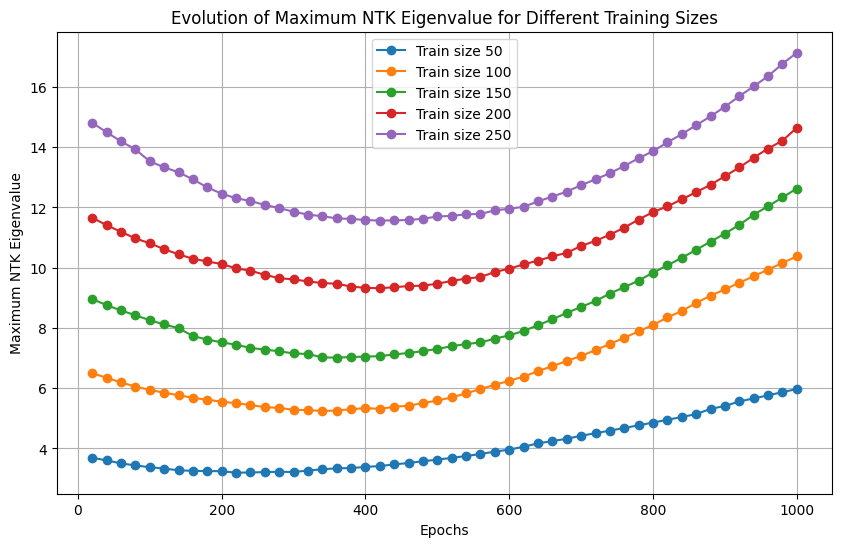

In [17]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l2=0.0001):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l2 * l2_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()


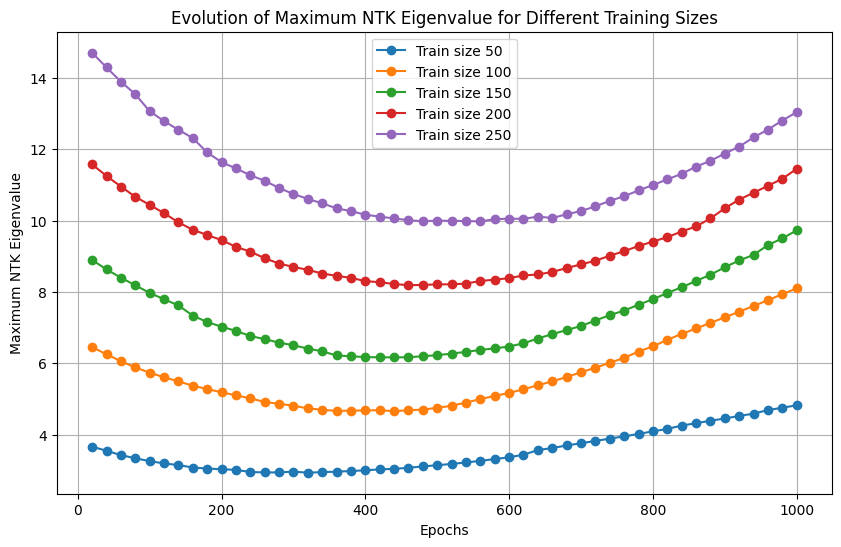

In [18]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l2=0.001):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l2 * l2_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()


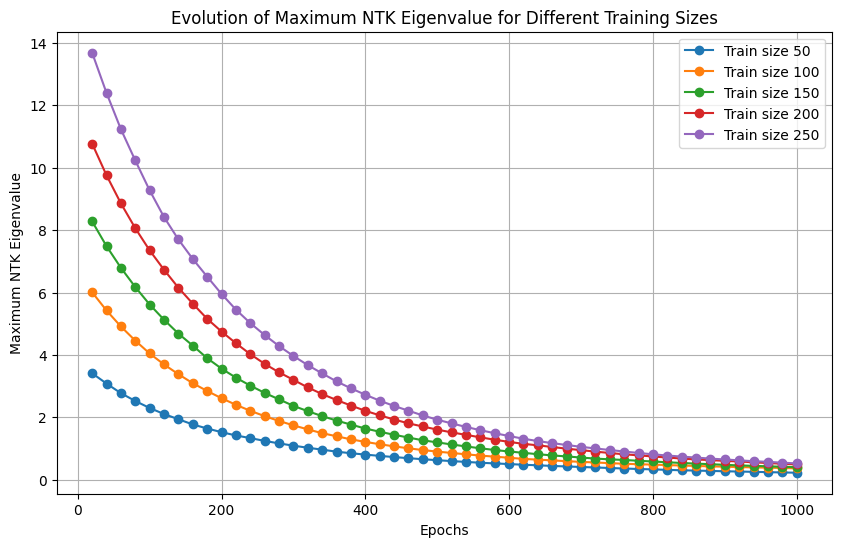

In [19]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l2=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l2 * l2_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()


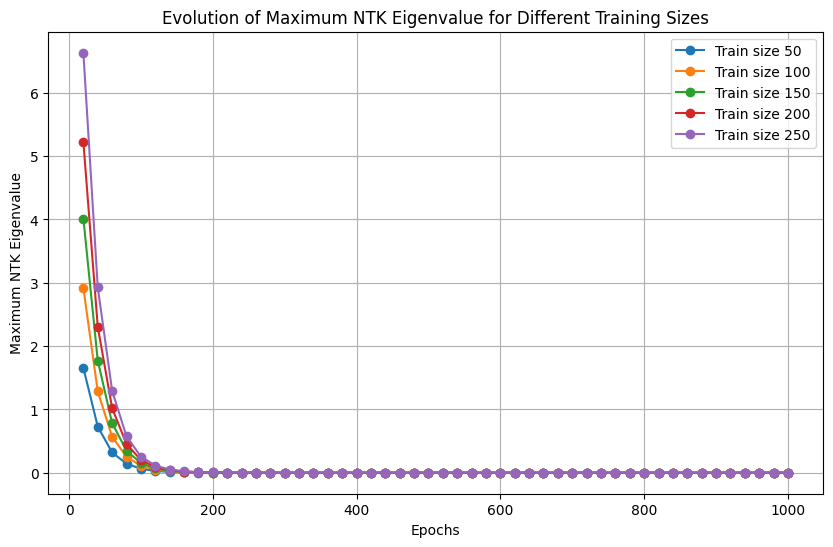

In [20]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l2=0.1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l2 * l2_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()


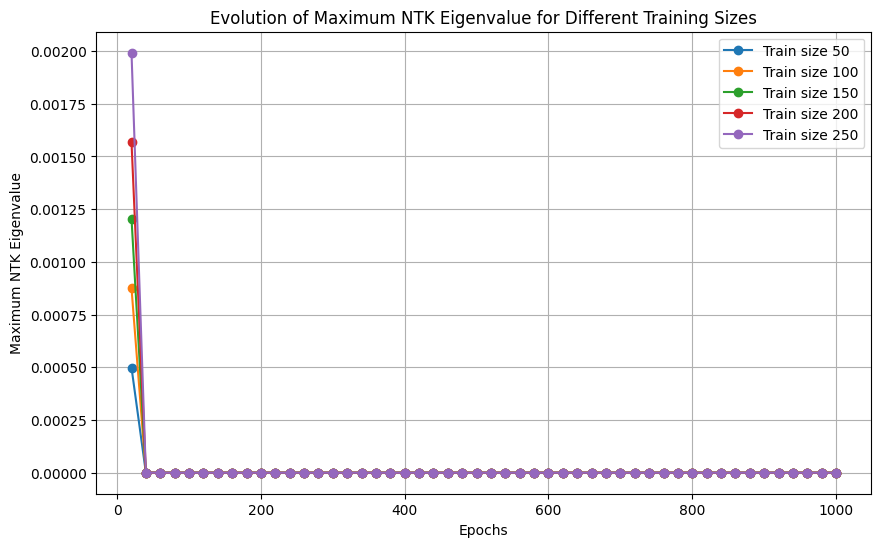

In [22]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l2= 1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l2 * l2_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue for Different Training Sizes")
plt.legend()
plt.grid(True)
plt.show()


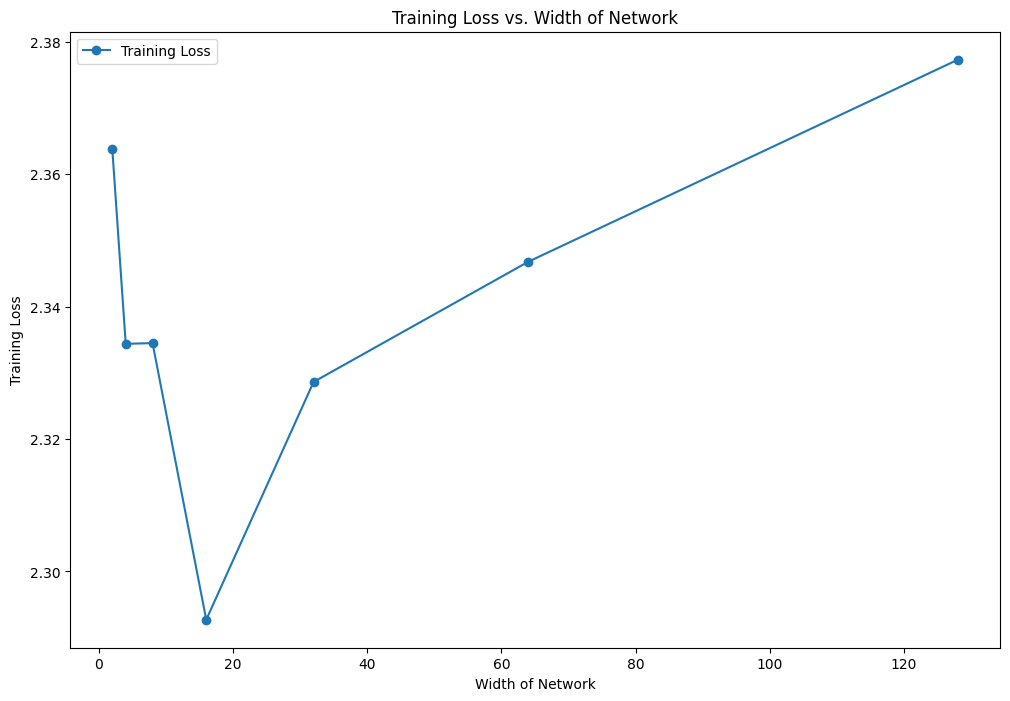

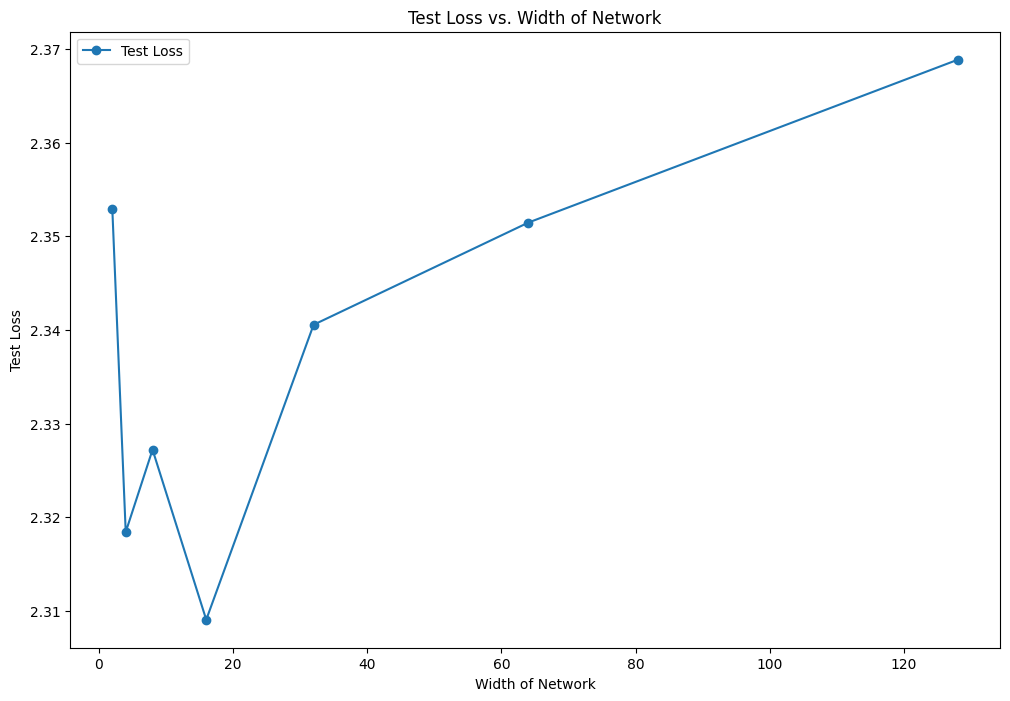

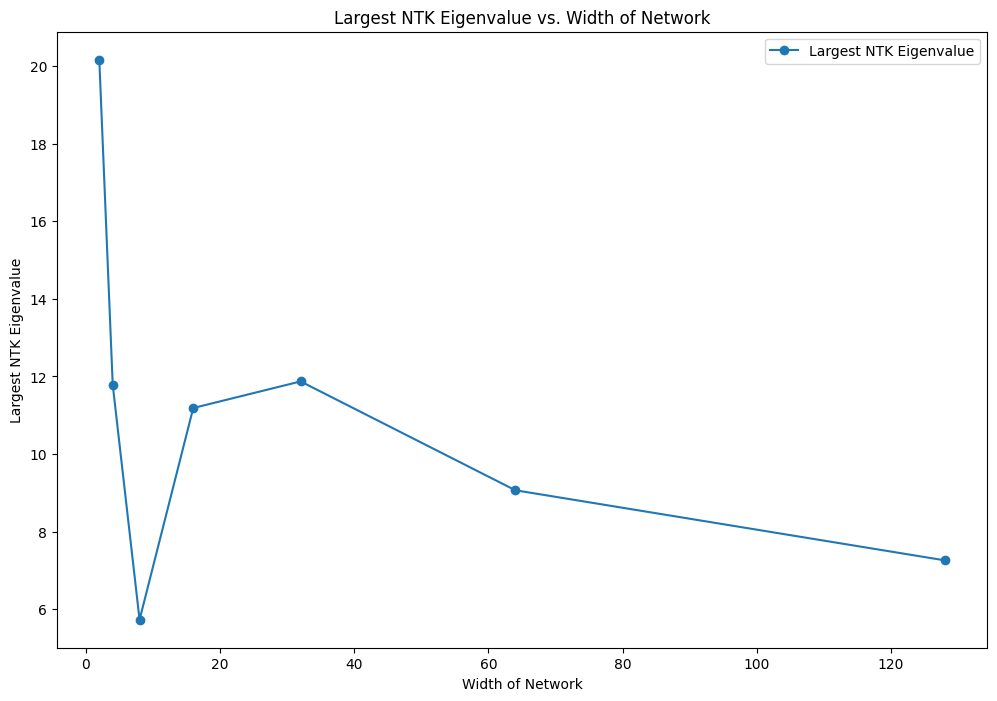

In [15]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_largest_ntk_eigenvalue(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return max(eigvals)

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    largest_eigenvalues = []
    training_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute largest NTK eigenvalue
        largest_eigenvalue = compute_largest_ntk_eigenvalue(apply_fn, params, x_train[:train_size])
        largest_eigenvalues.append(largest_eigenvalue)
        
        # Compute training loss
        train_loss = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(train_loss)
        
        # Compute test loss
        test_loss = loss_fn(params, x_test, y_test)
        test_losses.append(test_loss)
    
    return largest_eigenvalues, training_losses, test_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [2, 4, 8, 16, 32, 64, 128]  # Different network widths
train_size = 200  # Keeping training size constant
results = {}

for width in widths:
    largest_eigenvalues, training_losses, test_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (largest_eigenvalues, training_losses, test_losses)

# Plot training loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][1][-1] for w in widths], marker='o', label='Training Loss')
plt.xlabel("Width of Network")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss vs. Width of Network")
plt.show()

# Plot test loss vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][2][-1] for w in widths], marker='o', label='Test Loss')
plt.xlabel("Width of Network")
plt.ylabel("Test Loss")
plt.legend()
plt.title("Test Loss vs. Width of Network")
plt.show()

# Plot largest eigenvalue vs. width
plt.figure(figsize=(12, 8))
plt.plot(widths, [results[w][0][-1] for w in widths], marker='o', label='Largest NTK Eigenvalue')
plt.xlabel("Width of Network")
plt.ylabel("Largest NTK Eigenvalue")
plt.legend()
plt.title("Largest NTK Eigenvalue vs. Width of Network")
plt.show()


Width=2: Mean=0.1666, Variance=2.0797, Skewness=13.3779, Kurtosis=181.7902
Width=4: Mean=0.1245, Variance=0.7265, Skewness=12.8956, Kurtosis=172.3652
Width=8: Mean=0.0786, Variance=0.1816, Skewness=11.8969, Kurtosis=152.4030
Width=16: Mean=0.1099, Variance=0.6351, Skewness=13.4445, Kurtosis=183.5995
Width=32: Mean=0.1243, Variance=0.7188, Skewness=13.3233, Kurtosis=181.2677
Width=64: Mean=0.1055, Variance=0.4197, Skewness=13.2617, Kurtosis=180.1355
Width=128: Mean=0.0929, Variance=0.2706, Skewness=13.1154, Kurtosis=177.3165


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

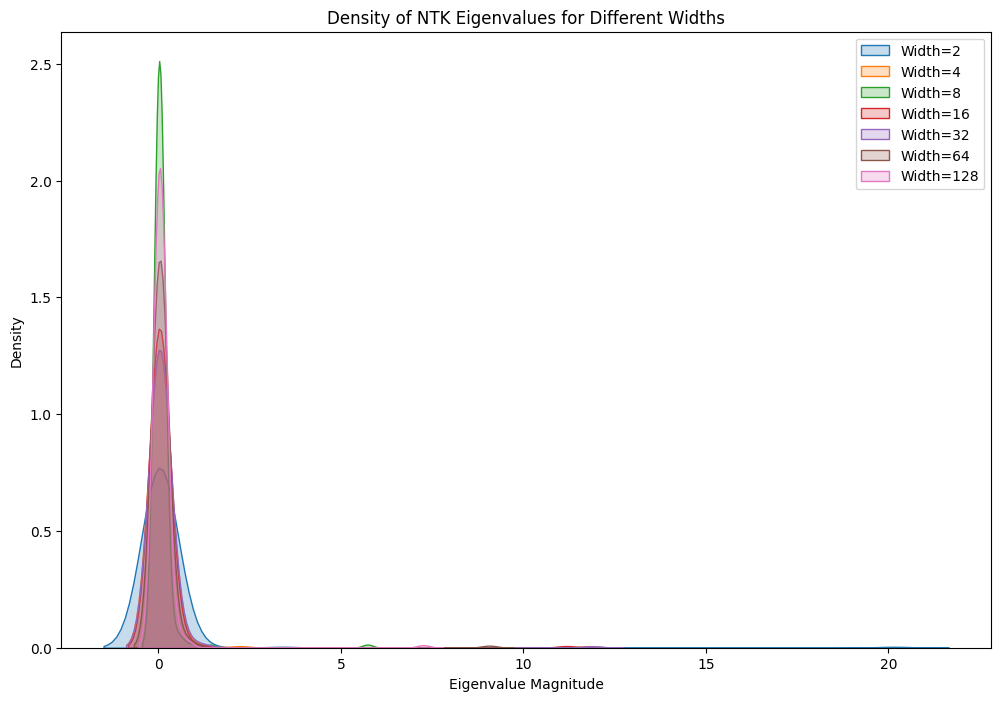

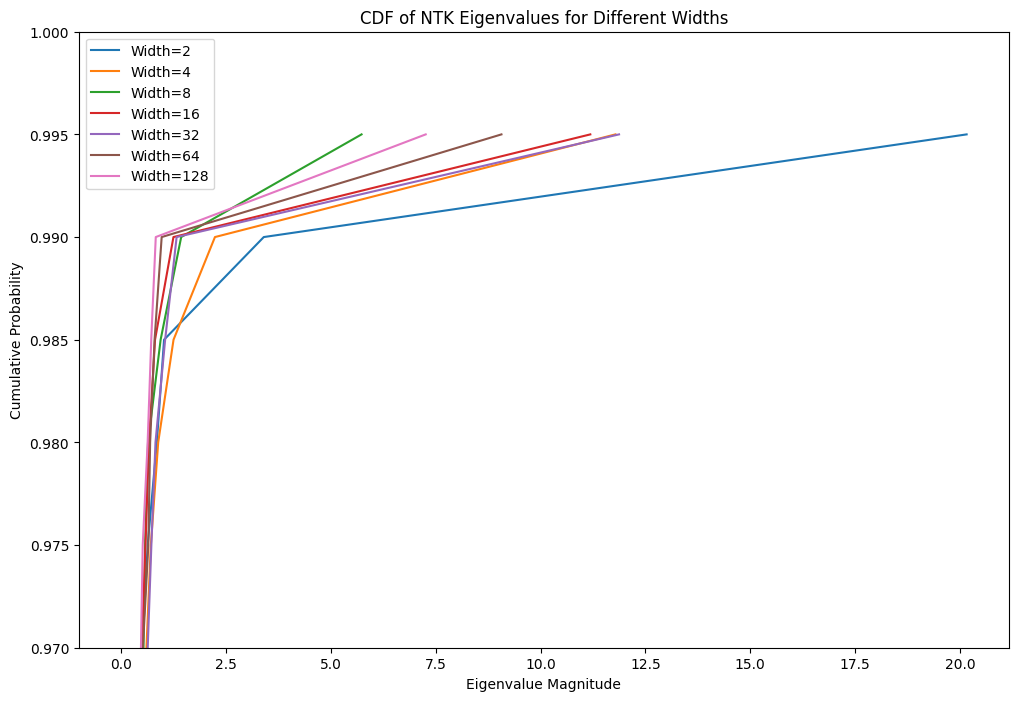

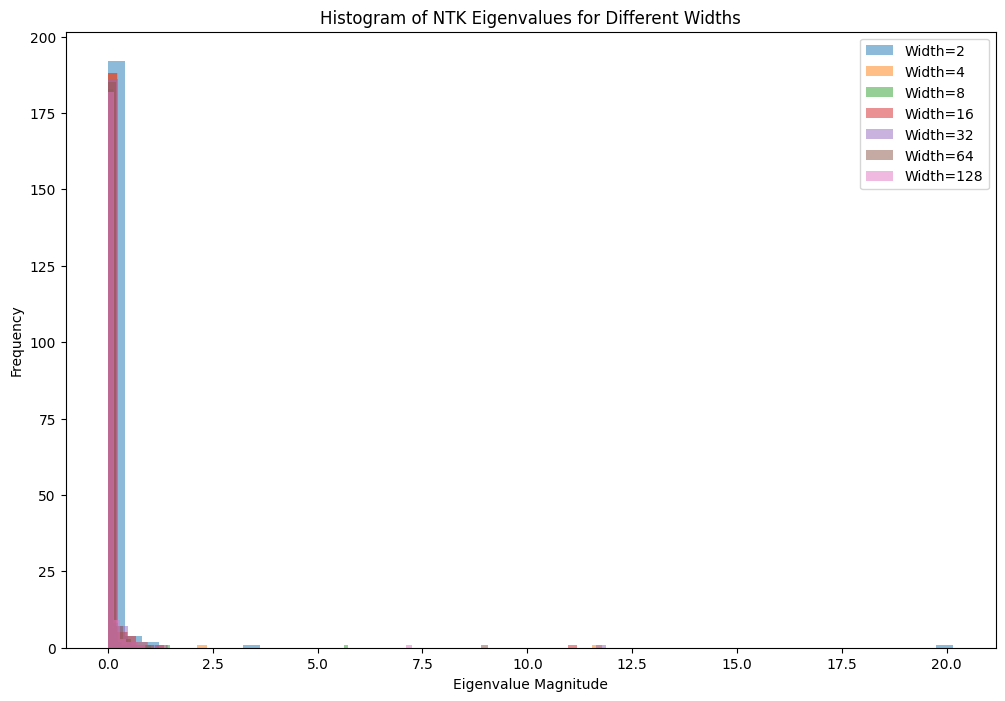

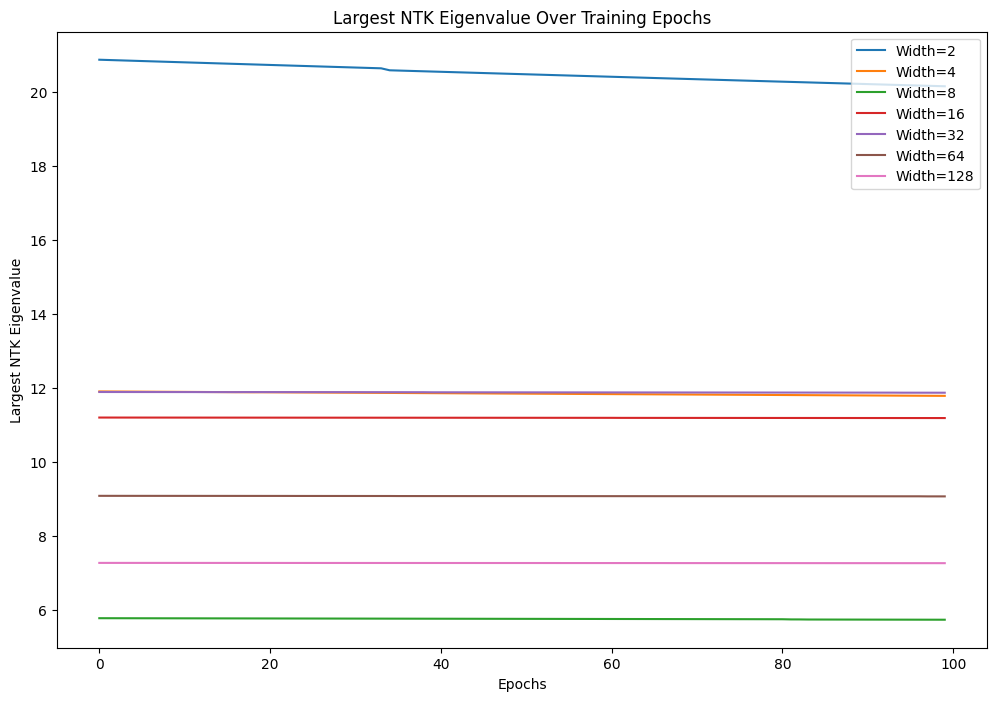

In [4]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define an MLP model
def create_mlp(width):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(width), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues
def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L2=0
def train_mlp(x_train, y_train, width, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp(width)
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function (L2 = 0)
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    # Get gradients
    grad_fn = grad(loss_fn)

    eigenvalue_spectra = []
    training_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        # Compute NTK eigenvalues
        eigenvalues = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
        eigenvalue_spectra.append(eigenvalues)
        
        # Compute training loss
        train_loss = loss_fn(params, x_train[:train_size], y_train[:train_size])
        training_losses.append(train_loss)
        
        # Compute test loss
        test_loss = loss_fn(params, x_test, y_test)
        test_losses.append(test_loss)
    
    return eigenvalue_spectra, training_losses, test_losses

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
widths = [2, 4, 8, 16, 32, 64, 128]  # Different network widths
train_size = 200  # Keeping training size constant
results = {}

for width in widths:
    eigenvalue_spectra, training_losses, test_losses = train_mlp(x_train, y_train, width, train_size)
    results[width] = (eigenvalue_spectra, training_losses, test_losses)

# Statistical analysis of NTK eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]  # Final epoch eigenvalues
    mean_val = jnp.mean(eigvals)
    var_val = jnp.var(eigvals)
    skew_val = stats.skew(eigvals)
    kurtosis_val = stats.kurtosis(eigvals)
    print(f"Width={width}: Mean={mean_val:.4f}, Variance={var_val:.4f}, Skewness={skew_val:.4f}, Kurtosis={kurtosis_val:.4f}")
    
    sns.kdeplot(eigvals, label=f'Width={width}', fill=True)

plt.xlabel("Eigenvalue Magnitude")
plt.ylabel("Density")
plt.legend()
plt.title("Density of NTK Eigenvalues for Different Widths")
plt.show()

# Cumulative Distribution Function (CDF) of Eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]
    sorted_eigvals = jnp.sort(eigvals)
    cdf = jnp.arange(len(sorted_eigvals)) / len(sorted_eigvals)
    plt.plot(sorted_eigvals, cdf, label=f'Width={width}')

plt.xlabel("Eigenvalue Magnitude")
plt.ylim(0.97,1)
plt.ylabel("Cumulative Probability")
plt.legend()
plt.title("CDF of NTK Eigenvalues for Different Widths")
plt.show()

# Histogram of Eigenvalues
plt.figure(figsize=(12, 8))
for width in widths:
    eigvals = results[width][0][-1]
    plt.hist(eigvals, bins=50, alpha=0.5, label=f'Width={width}')

plt.xlabel("Eigenvalue Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of NTK Eigenvalues for Different Widths")
plt.show()

# Track the largest eigenvalue over epochs
plt.figure(figsize=(12, 8))
for width in widths:
    largest_eigenvalues = [epoch_eigvals[-1] for epoch_eigvals in results[width][0]]
    plt.plot(range(len(largest_eigenvalues)), largest_eigenvalues, label=f'Width={width}')

plt.xlabel("Epochs")
plt.ylabel("Largest NTK Eigenvalue")
plt.legend()
plt.title("Largest NTK Eigenvalue Over Training Epochs")
plt.show()